In [1]:
# Importing libraries
import re
import sys
import json
import praw
import math
import string
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.lda_model
from itertools import chain
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
from praw.models import MoreComments

# Importing Scikit-learn libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Importing NLTK libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# networkx library for graph visualization
import networkx as nx
from networkx.algorithms import community

# Downloading NLTK stopwords
nltk.download('stopwords')
# Downloading NLTK vader lexicon
nltk.download('vader_lexicon')
# Downloading NLTK punkt tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-v0_8")

# Setting aesthetic parameters for plots
sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

In [3]:

# Path to your JSON file
file_path = '../Data/youtube_merged_all_videos_with_comments.json'


# Load the JSON data
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Build a list of records: one 'video' row (title+description) followed by its comments
records = []
for video in data:
    vid = video.get('videoId', '')
    title = video.get('title', '')
    desc = video.get('description', '')
    channelTitle = video.get('channelTitle', '')
    videoPublishedAt = video.get('videoPublishedAt', '')
    tags = video.get('tags', [])
    viewCount = video.get('viewCount', 0)
    videoLikeCount = video.get('videoLikeCount', 0)
    videoCommentCount = video.get('videoCommentCount', 0)
    comment_count = len(video.get('comments', []))

    # First row: title + description
    records.append({
        'videoId': vid,
        'title': title,
        'description': desc,
        'channelTitle': channelTitle,
        'videoPublishedAt': videoPublishedAt,
        'tags': tags,
        'viewCount': viewCount,
        'videoLikeCount': videoLikeCount,
        'videoCommentCount': videoCommentCount,
        'text': f"{title}\n\n{desc}",
        'comment_count': comment_count,
        'type': 'video'

    })
    # Subsequent rows: each comment
    for comment in video.get('comments', []):
        comment_text = comment.get('text', '')
        comment_author = comment.get('author', '')
        comment_published_at = comment.get('publishedAt', '')
        comment_like_count = comment.get('likeCount', 0)
        records.append({
            'videoId': vid,
            'c_text': comment_text,
            'c_author': comment_author,
            'c_publishedAt': comment_published_at,
            'c_likeCount': comment_like_count,
            'type': 'comment'
        })


        
# Create DataFrame
df_vid_comments = pd.DataFrame(records)


In [4]:
df_vid_comments.head(5)

videoId                                              title  \
0  2JsmSs3oPjc  Russia in 'far worse position now' than during...   
1  2JsmSs3oPjc                                                NaN   
2  2JsmSs3oPjc                                                NaN   
3  2JsmSs3oPjc                                                NaN   
4  2JsmSs3oPjc                                                NaN   

                                         description channelTitle  \
0  Russia is in a "far worse position now" compar...     Sky News   
1                                                NaN          NaN   
2                                                NaN          NaN   
3                                                NaN          NaN   
4                                                NaN          NaN   

       videoPublishedAt                                               tags  \
0  2025-05-16T14:37:44Z  ukraine;russia;war;conflict;analysis;professor...   
1                   NaN                                                NaN   
2                   NaN                                                NaN   
3                   NaN                                                NaN   
4                   NaN                                                NaN   

   viewCount  videoLikeCount  videoCommentCount  \
0   392688.0          4944.0             1558.0   
1        NaN             NaN                NaN   
2        NaN             NaN                NaN   
3        NaN             NaN                NaN   
4        NaN             NaN                NaN   

                                                text  comment_count     type  \
0  Russia in 'far worse position now' than during...          954.0    video   
1                                                NaN            NaN  comment   
2                                                NaN            NaN  comment   
3                                                NaN            NaN  comment   
4                                                NaN            NaN  comment   

                                              c_text           c_author  \
0                                                NaN                NaN   
1  I only clicked to see how the bias from sky wa...       @NeilCubbage   
2  The Russians have moved 30 miles through heavy...    @haydnjones4816   
3                              I'm tired of this guy  @incognito_one876   
4  Clarke is a Govt propaganda stooge from Chatha...       @saviour5091   

          c_publishedAt  c_likeCount  
0                   NaN          NaN  
1  2025-05-22T10:44:58Z          0.0  
2  2025-05-22T09:33:14Z          0.0  
3  2025-05-22T09:10:04Z          0.0  
4  2025-05-22T08:43:16Z          0.0

In [5]:
df_vid_comments.columns

Index(['videoId', 'title', 'description', 'channelTitle', 'videoPublishedAt',
       'tags', 'viewCount', 'videoLikeCount', 'videoCommentCount', 'text',
       'comment_count', 'type', 'c_text', 'c_author', 'c_publishedAt',
       'c_likeCount'],
      dtype='object')

In [6]:
# Top 5 videos with the most videos likes
top_5_vid_likes = df_vid_comments[['videoId', 'title', 'tags', 'channelTitle', 'videoPublishedAt', 'viewCount', 'videoLikeCount', 'videoCommentCount']].sort_values(by='videoLikeCount', ascending=False).head(5)


In [7]:
top_5_vid_likes

videoId                                              title  \
9341   HCLzN8Xprbk  What Russia Plans for Ukraine? #russia #ukrain...   
4766   vzGqN89ifBI  Abrams and Leopard vs. Russian Tank T-90M. Wes...   
11605  mK7vxYdaIxU  🔴 Ukraine War Update - Ukrainians In Heavy Clo...   
5696   MyO3ObbxxeM  Putin MELTS DOWN as Ukraine’s Drones HIT Mosco...   
13082  k7WHP9UPq24                  RUSSIA vs UKRAINE - 2 Years Later   

                                                    tags  \
9341   dmitry medvedev;ghost countries;geography;geop...   
4766   Abrams;Abrams in Ukraine;Abrams on battlefield...   
11605  ukraine war update;russia vs ukraine war updat...   
5696                        military;navy;army;air force   
13082                                                NaN   

                   channelTitle      videoPublishedAt  viewCount  \
9341            Ghost Countries  2024-05-11T13:45:01Z  1879369.0   
4766                   UNITED24  2025-05-08T16:36:46Z  1756300.0   
11605  WarLeaks - Military Blog  2025-04-27T13:01:27Z   841138.0   
5696          The Military Show  2025-05-08T17:03:48Z  1282150.0   
13082     The Infographics Show  2024-02-25T20:15:02Z   631492.0   

       videoLikeCount  videoCommentCount  
9341          61158.0             5108.0  
4766          31054.0             1381.0  
11605         29723.0              702.0  
5696          27070.0             1528.0  
13082         14013.0             2001.0

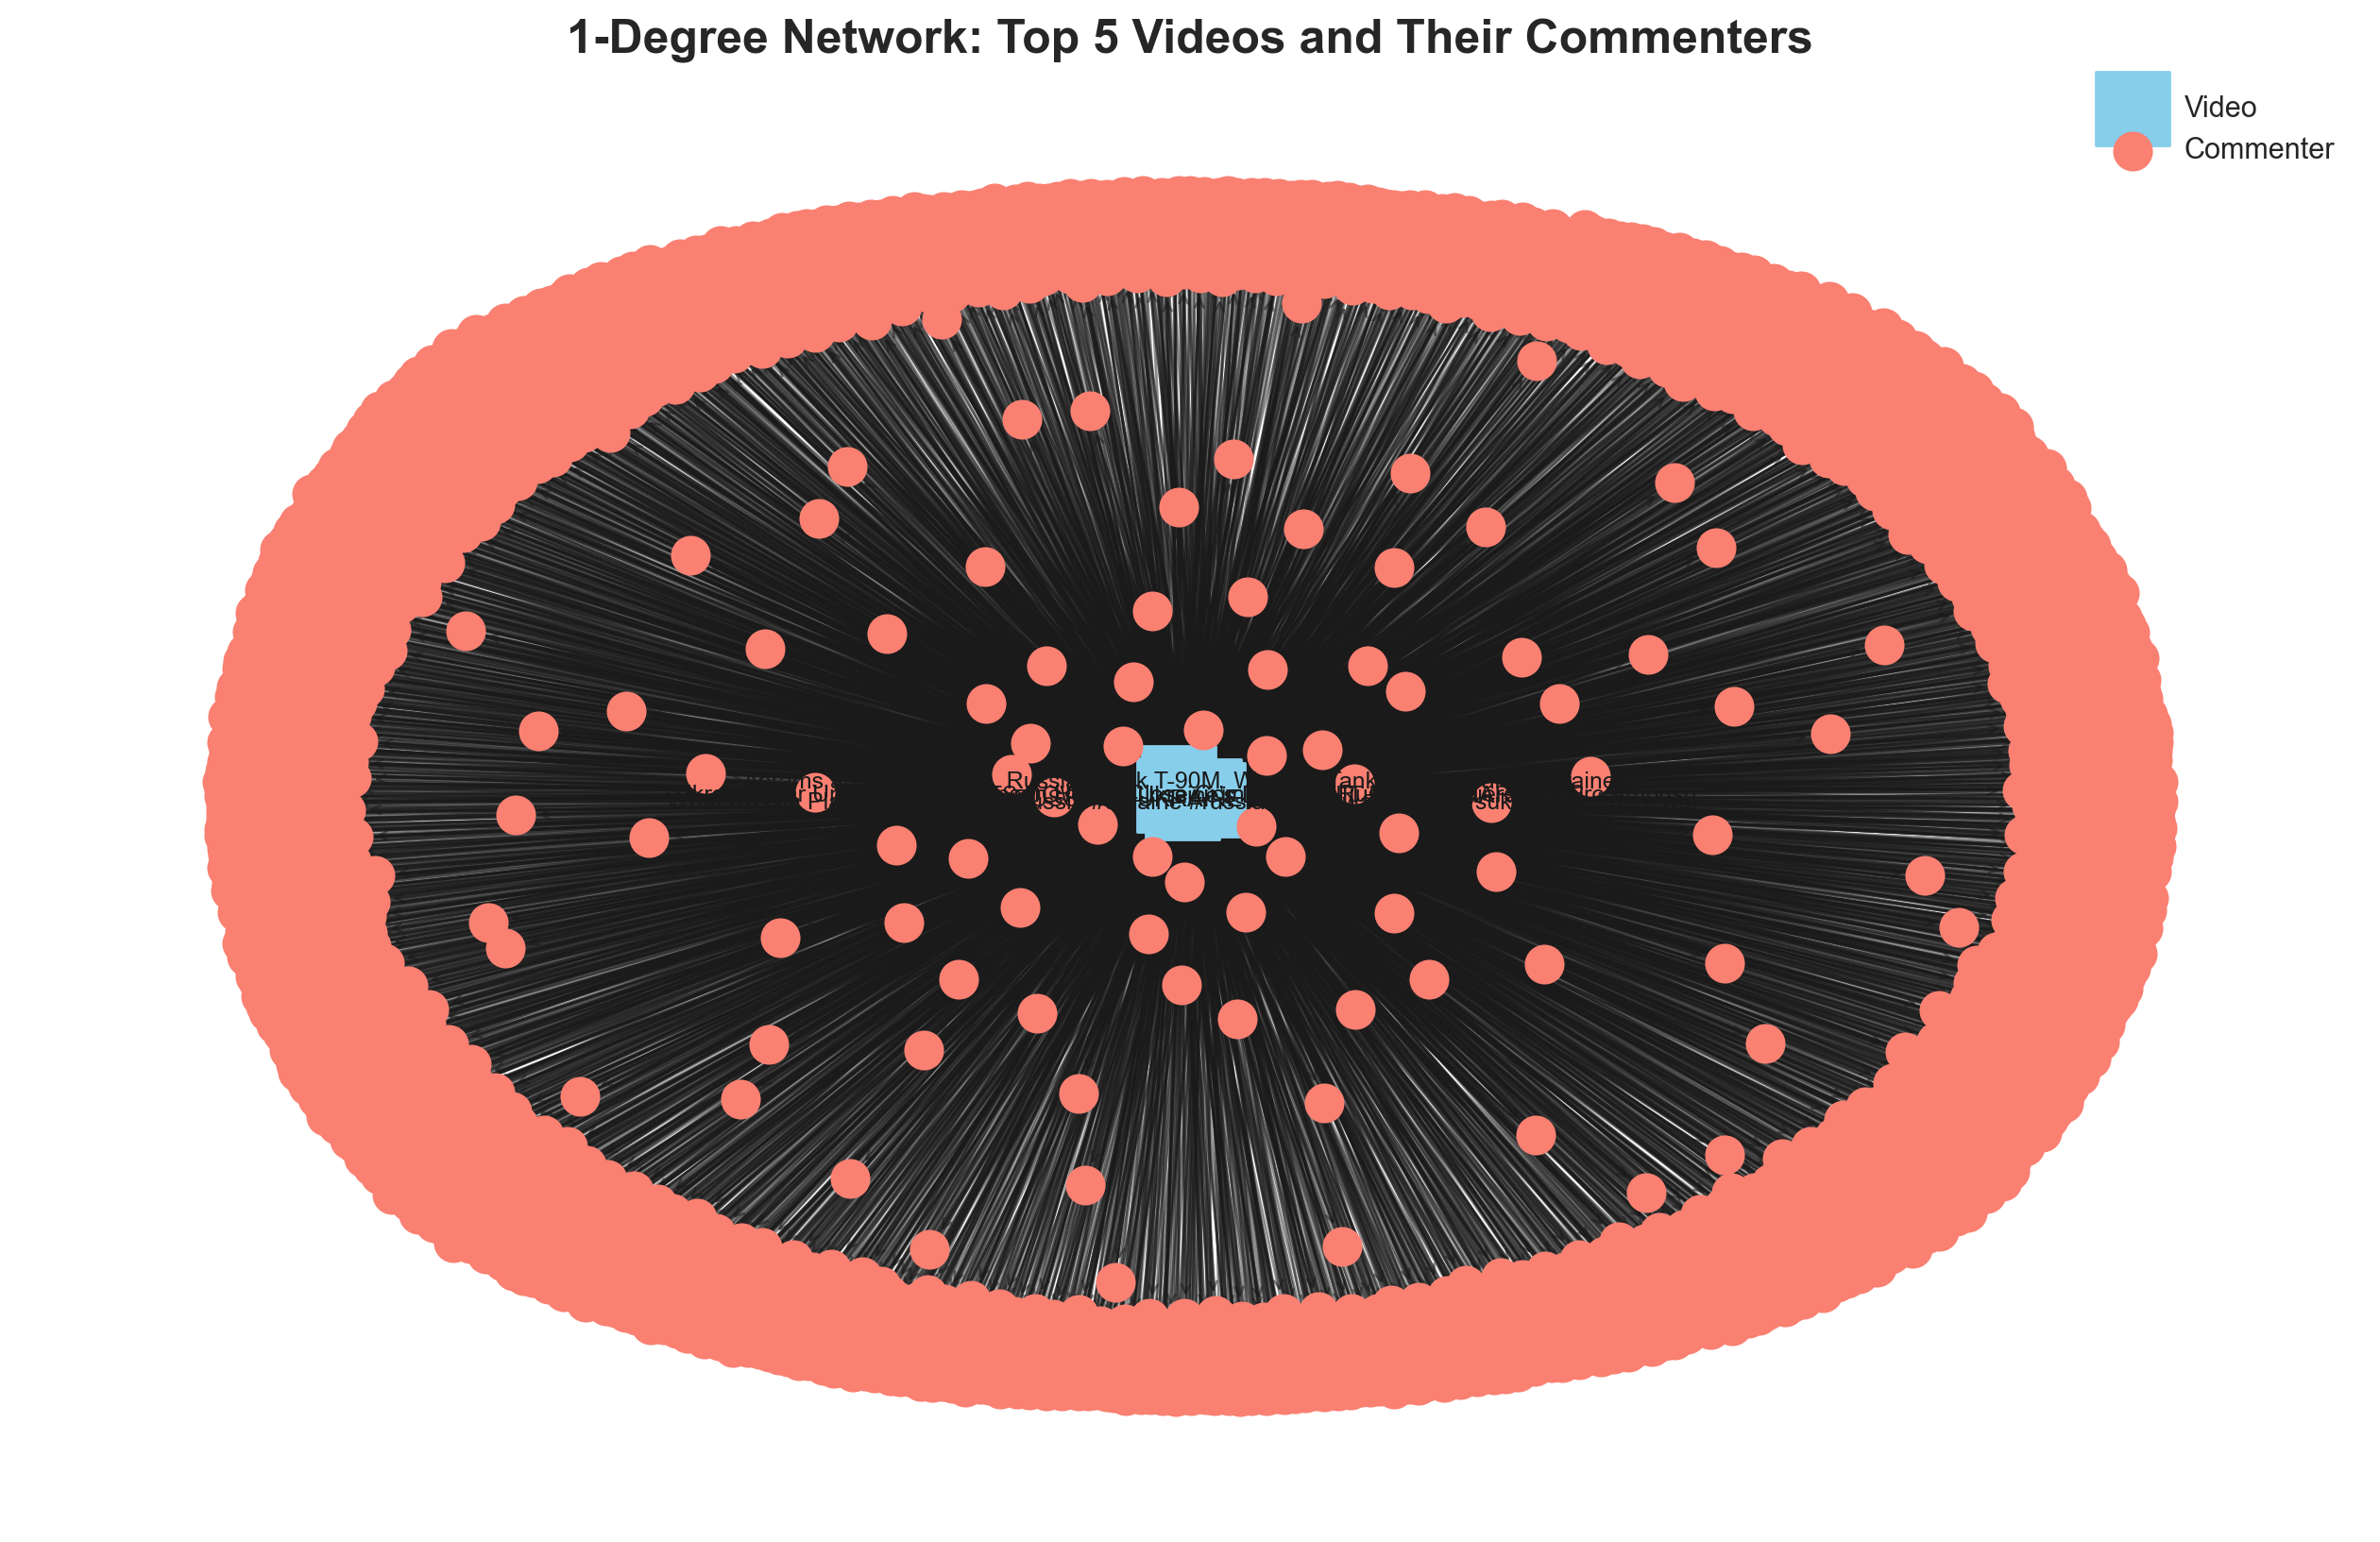

In [8]:

# Assume df_vid_comments is your DataFrame
# 1) Select only the “video” rows and pick top 5 by like count
videos = df_vid_comments[df_vid_comments['type'] == 'video']
top5_ids = videos.nlargest(5, 'videoLikeCount')['videoId'].tolist()

# 2) Initialize a directed graph
G = nx.DiGraph()

# 3) Add the top-5 video nodes (parents) with titles as labels
for vid in top5_ids:
    title = videos.loc[videos['videoId'] == vid, 'title'].iloc[0]
    G.add_node(vid, label=title, node_type='video')

# 4) Add commenter nodes (children) and edges from video → commenter
comments = df_vid_comments[df_vid_comments['type'] == 'comment']
for _, row in comments[comments['videoId'].isin(top5_ids)].iterrows():
    commenter = row['c_author']
    G.add_node(commenter, node_type='commenter')
    G.add_edge(row['videoId'], commenter)

# This is indeed a **1-degree connection** graph (every commenter is exactly one hop from its video).

# 5) Visualize
# plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

# separate nodes by type
video_nodes   = [n for n, d in G.nodes(data=True) if d['node_type'] == 'video']
comment_nodes = [n for n, d in G.nodes(data=True) if d['node_type'] == 'commenter']

# draw
nx.draw_networkx_nodes(G, pos, nodelist=video_nodes,   node_color='skyblue', node_shape='s', node_size=800, label='Video')
nx.draw_networkx_nodes(G, pos, nodelist=comment_nodes, node_color='salmon',  node_shape='o', node_size=200, label='Commenter')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=8, alpha=0.5)

# label only video nodes to reduce clutter
video_labels = {n: G.nodes[n]['label'] for n in video_nodes}
nx.draw_networkx_labels(G, pos, labels=video_labels, font_size=9)

plt.title('1-Degree Network: Top 5 Videos and Their Commenters')
plt.legend(scatterpoints=1)
plt.axis('off')
plt.show()


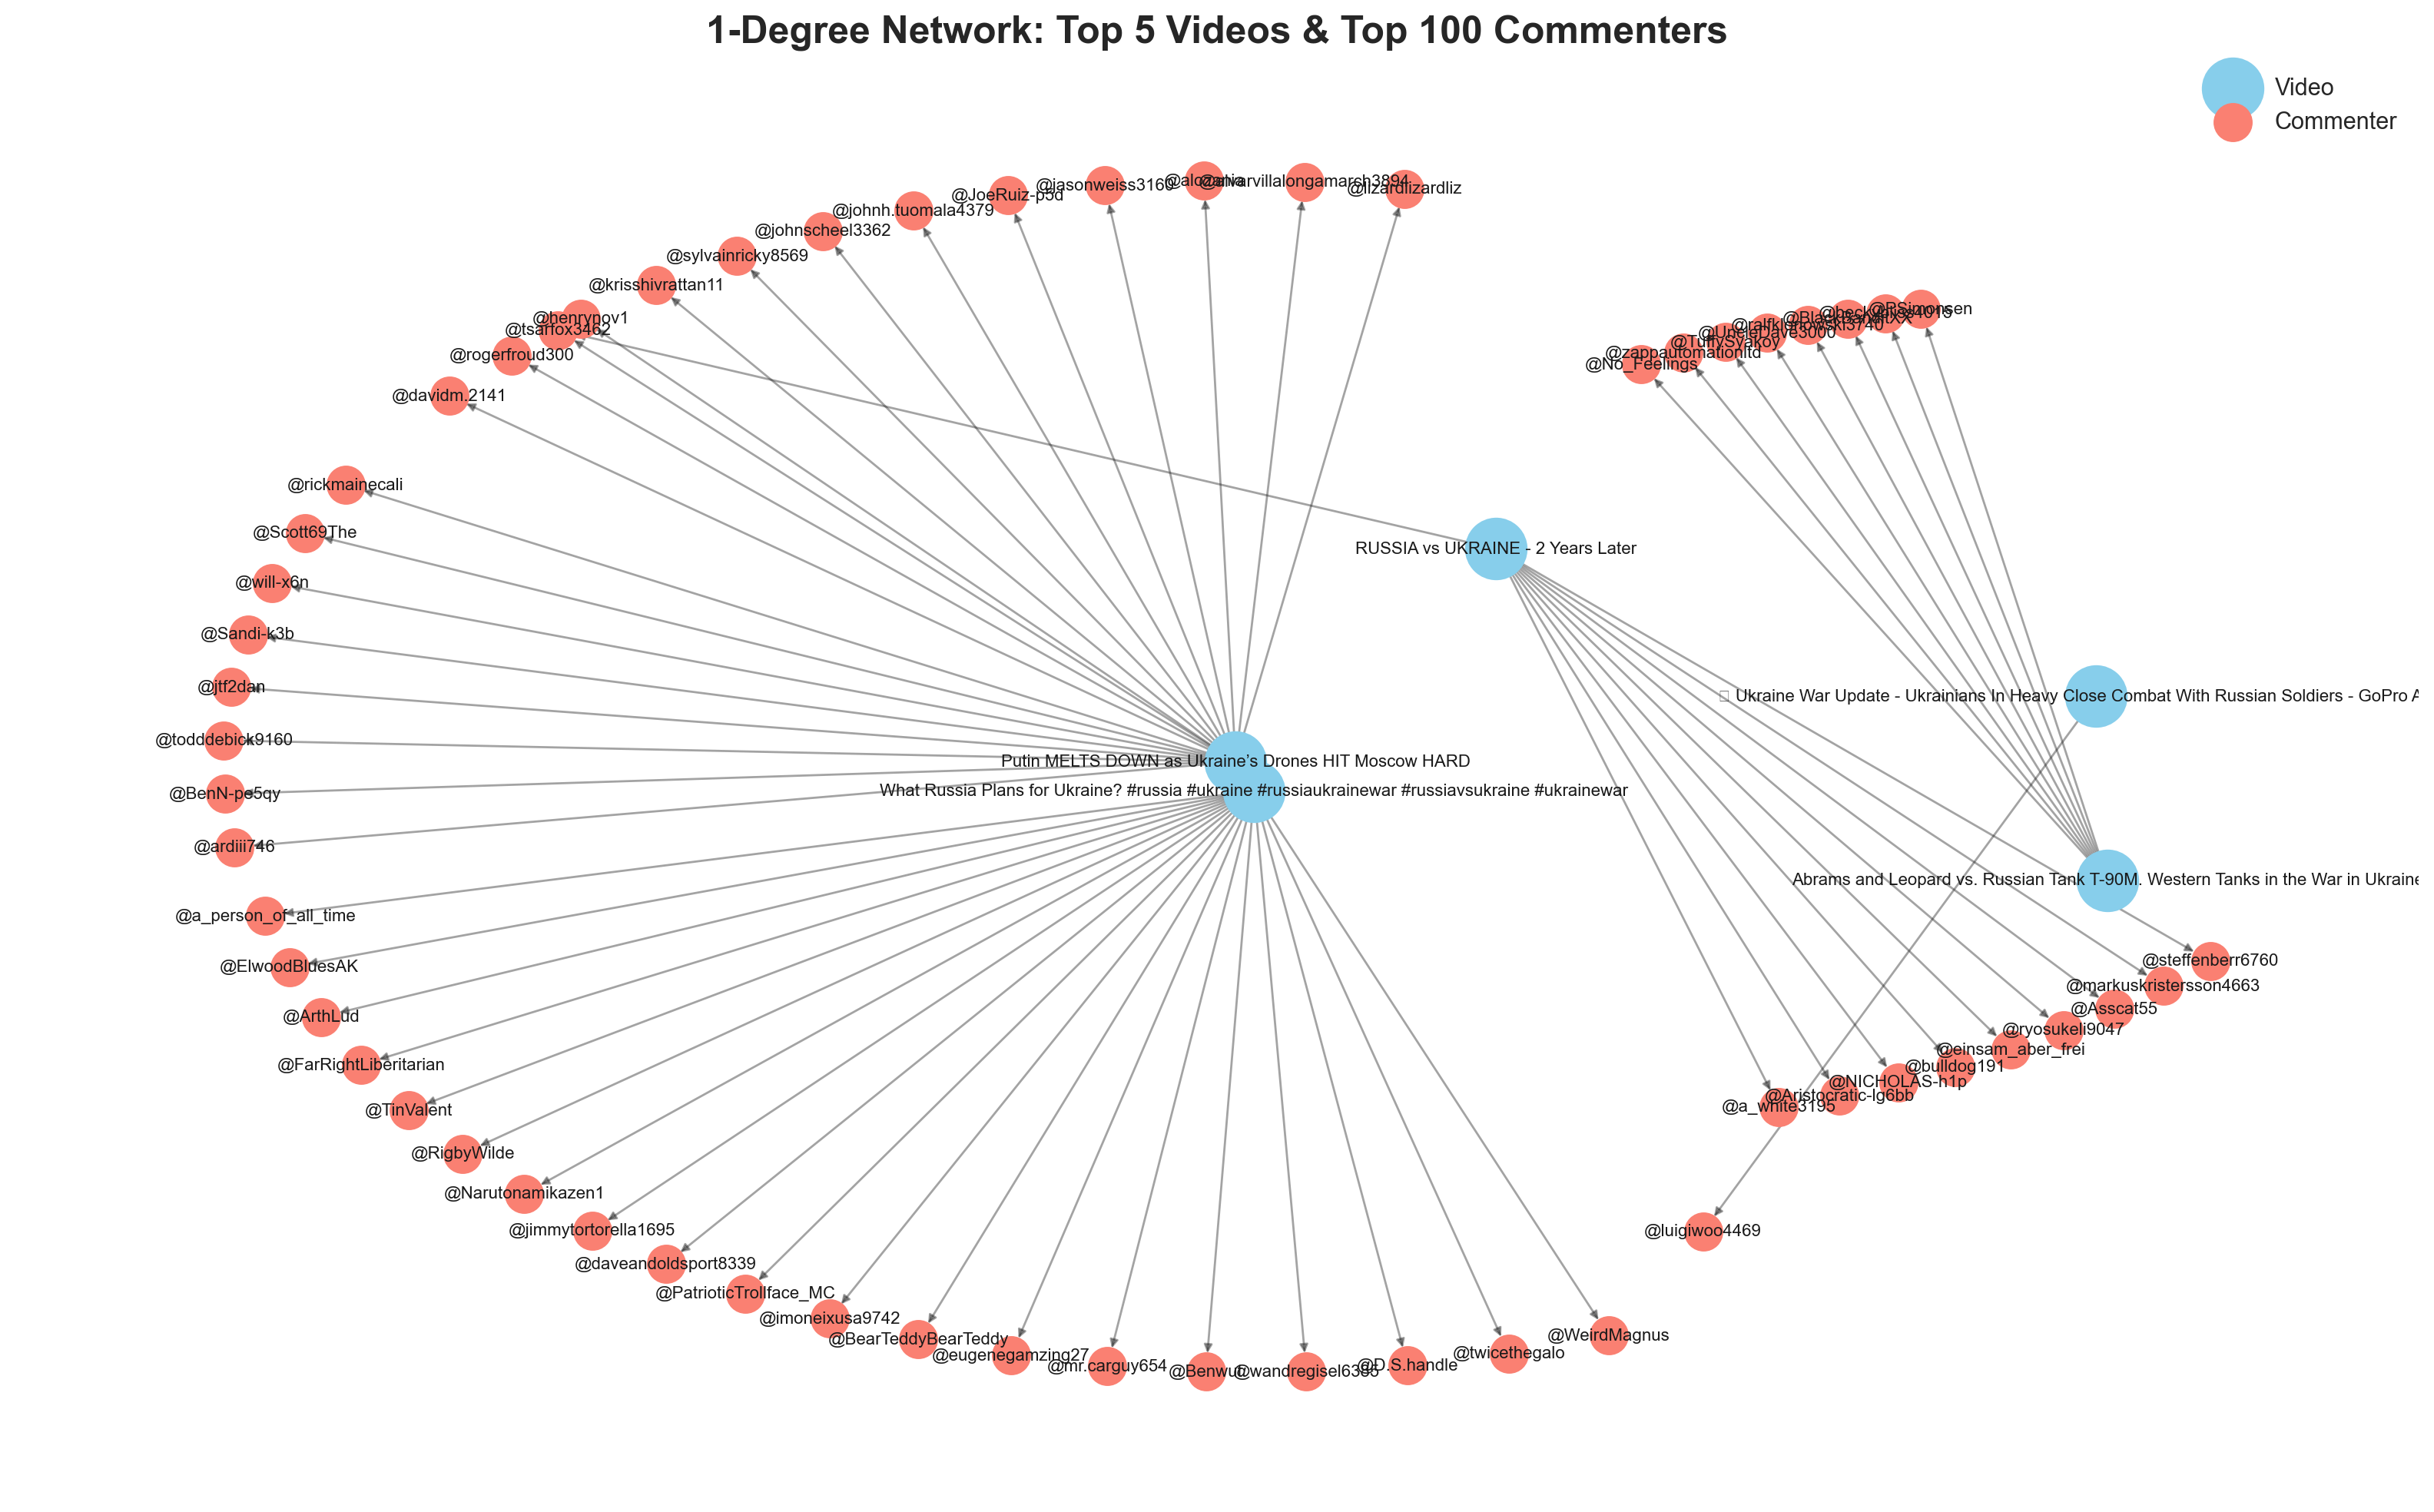

In [9]:


# 1. Identify top 5 videos by like count
videos = df_vid_comments[df_vid_comments['type']=='video']
top5_ids = videos.nlargest(5, 'videoLikeCount')['videoId'].tolist()

# 2. Identify top 10 commenters by total comment likes
comments = df_vid_comments[df_vid_comments['type']=='comment']
top10_commenters = (
    comments.groupby('c_author')['c_likeCount']
            .sum()
            .nlargest(100)
            .index
            .tolist()
)

# 3. Build the DiGraph
G = nx.DiGraph()
for vid in top5_ids:
    title = videos.loc[videos['videoId']==vid, 'title'].iloc[0]
    G.add_node(vid, label=title, bipartite='video')

for _, row in comments.loc[
        lambda d: d['videoId'].isin(top5_ids) & 
                  d['c_author'].isin(top10_commenters)
    ].iterrows():
    G.add_node(row['c_author'], bipartite='commenter')
    G.add_edge(row['videoId'], row['c_author'])

# 4. Create subgraph of just those nodes
nodes_to_keep = top5_ids + top10_commenters
H = G.subgraph(nodes_to_keep).copy()

# 5. Compute a layout (Kamada–Kawai)
pos = nx.kamada_kawai_layout(H)

# 6. Draw
# plt.figure(figsize=(10, 8))

# edges
nx.draw_networkx_edges(H, pos, alpha=0.4, arrowsize=8)

# nodes
video_nodes   = [n for n,d in H.nodes(data=True) if d['bipartite']=='video']
comment_nodes = [n for n,d in H.nodes(data=True) if d['bipartite']=='commenter']

nx.draw_networkx_nodes(
    H, pos,
    nodelist=video_nodes,
    node_color='skyblue',
    node_shape='o',
    node_size=800,
    label='Video'
)
nx.draw_networkx_nodes(
    H, pos,
    nodelist=comment_nodes,
    node_color='salmon',
    node_shape='o',
    node_size=300,
    label='Commenter'
)

# labels: videos by title, commenters by handle
labels = {
    n: (H.nodes[n]['label'] if n in video_nodes else n)
    for n in H.nodes()
}
nx.draw_networkx_labels(H, pos, labels, font_size=8)

plt.title("1-Degree Network: Top 5 Videos & Top 100 Commenters")
plt.legend(scatterpoints=1)
plt.axis('off')
plt.tight_layout()
plt.show()


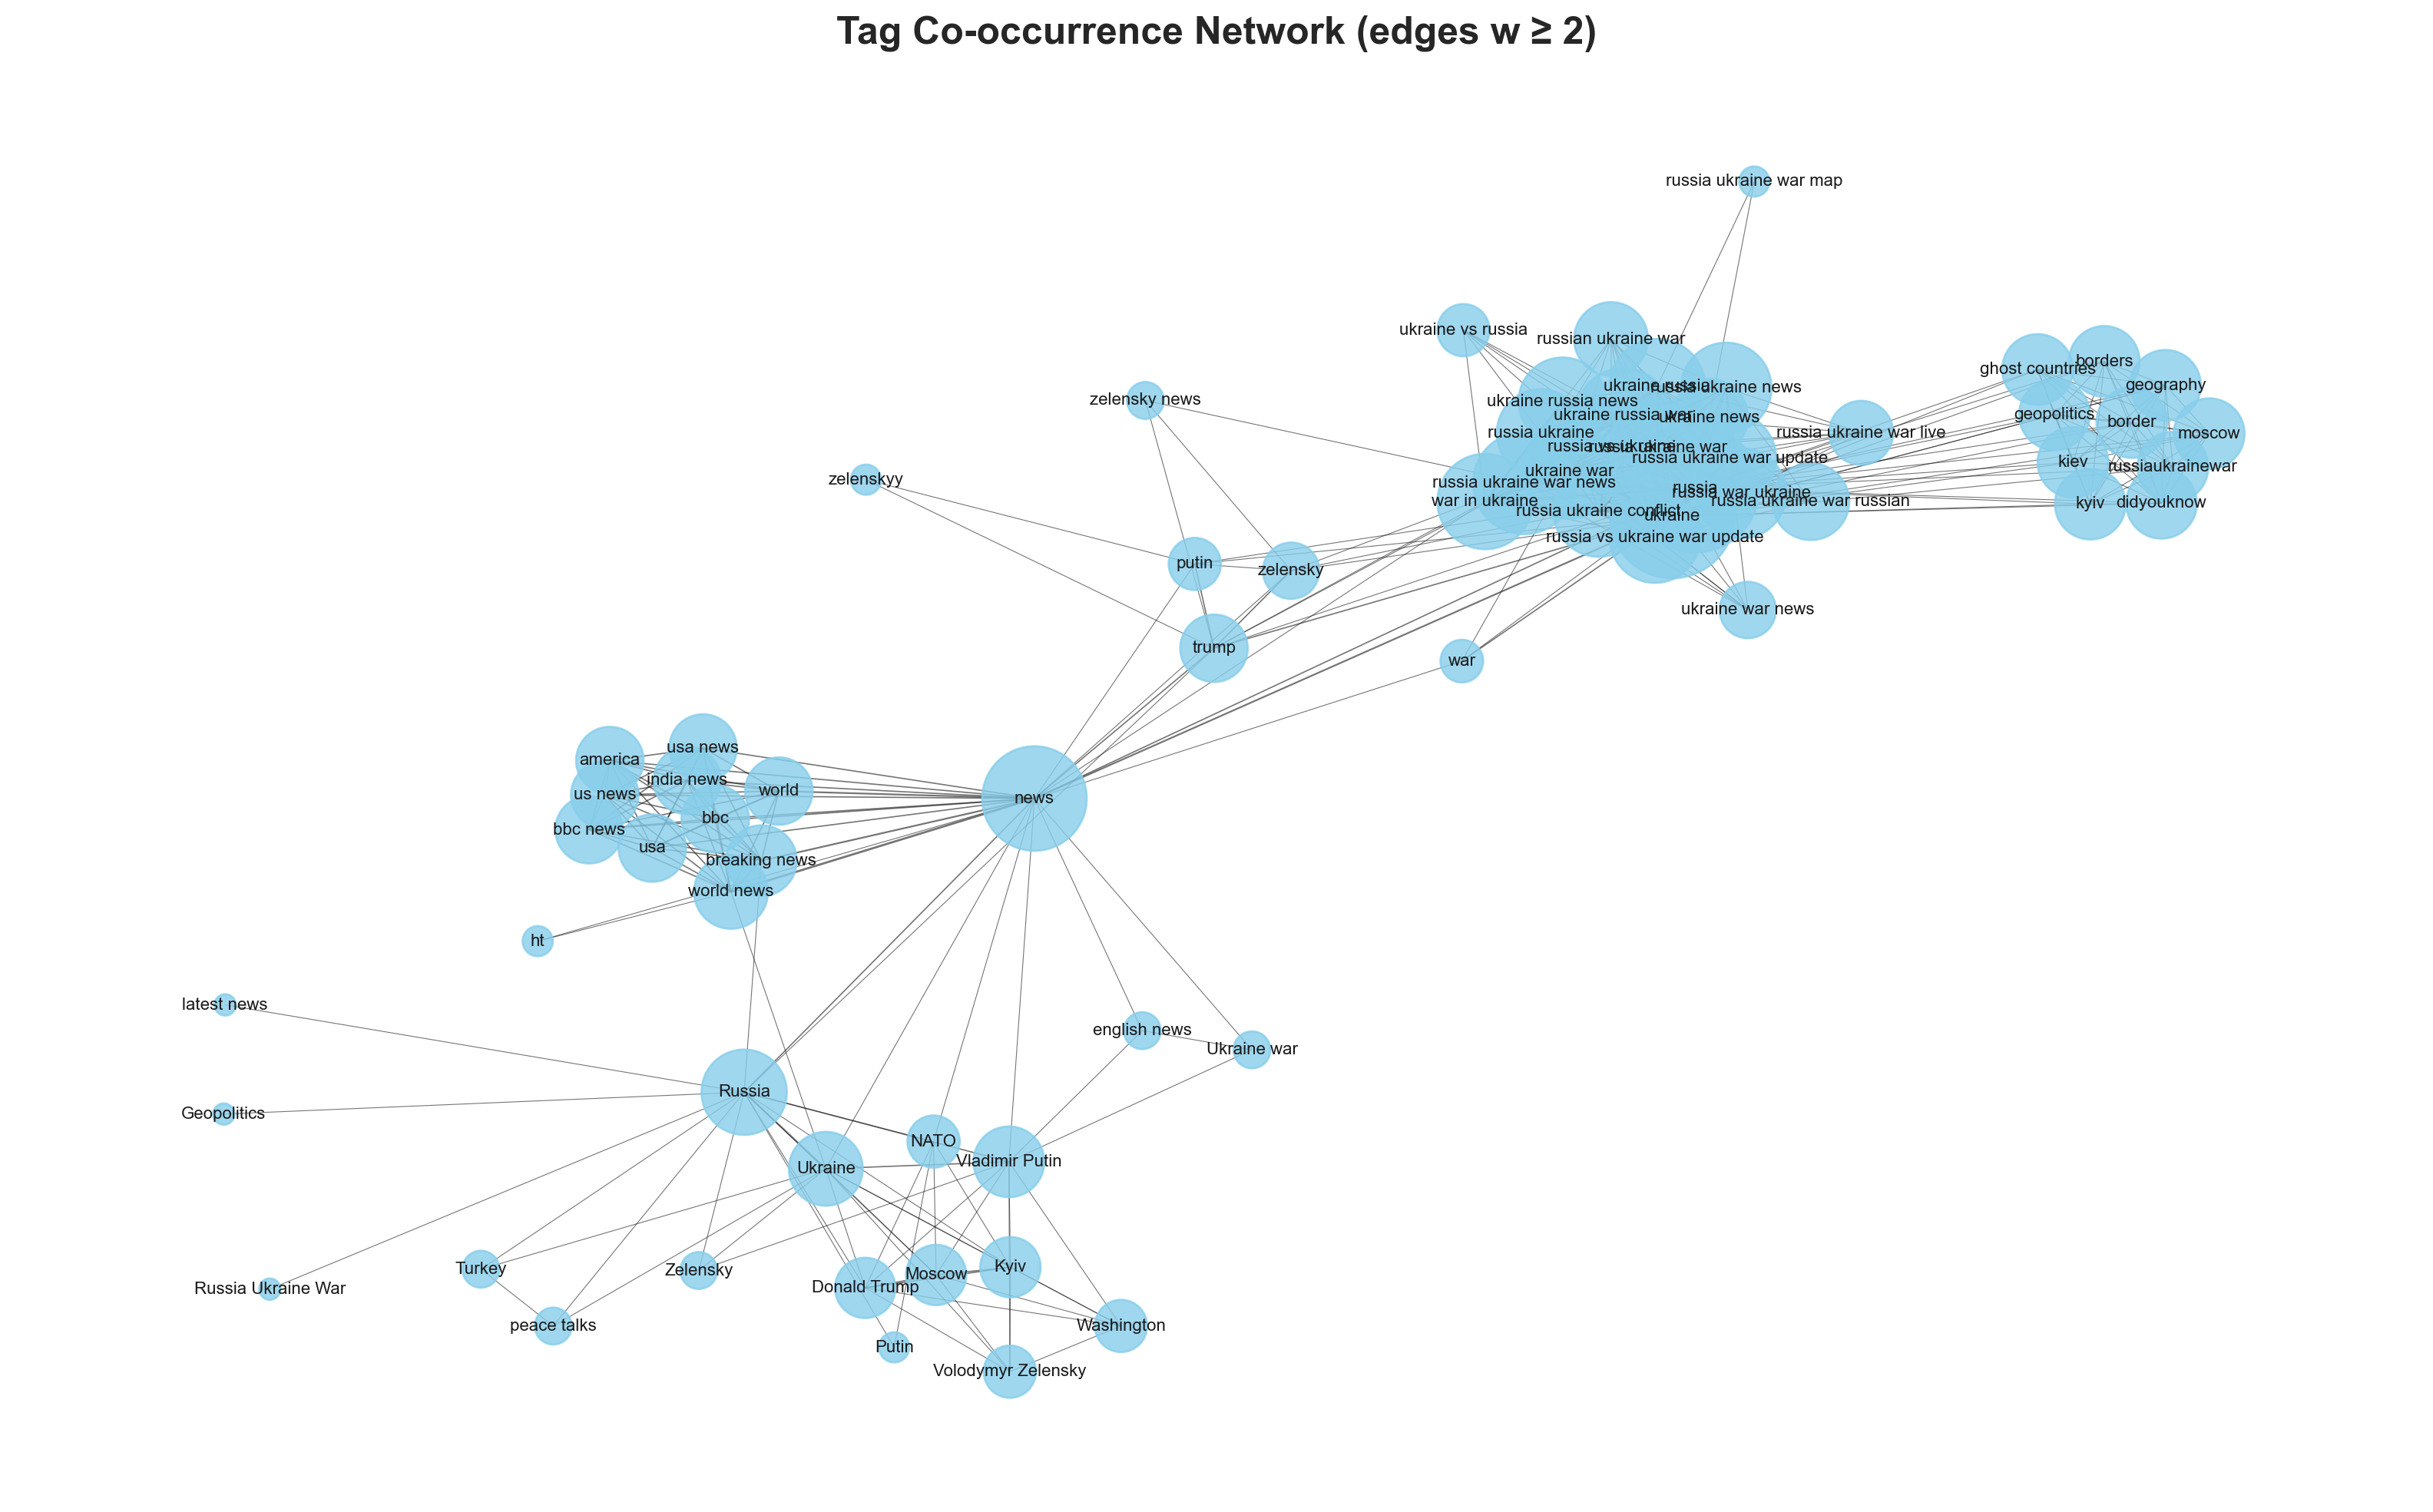

In [10]:


# 1) Filter to video rows and split tags into lists
videos = df_vid_comments[df_vid_comments['type'] == 'video'].copy()
videos = videos.dropna(subset=['tags'])
videos['tag_list'] = videos['tags'].apply(lambda s: s.split(';'))

# 2) Count co-occurrences of each tag pair
from collections import Counter
edge_weights = Counter()
for tags in videos['tag_list']:
    unique_tags = set(tags)
    for t1, t2 in itertools.combinations(sorted(unique_tags), 2):
        edge_weights[(t1, t2)] += 1

# 3) Build the graph, keeping only edges with weight ≥ 2
G_tag = nx.Graph()
for (t1, t2), w in edge_weights.items():
    if w >= 2:
        G_tag.add_edge(t1, t2, weight=w)

# 4) Layout and draw
pos = nx.spring_layout(G_tag, k=0.3, seed=42)

# draw edges: width proportional to weight
edges, weights = zip(*nx.get_edge_attributes(G_tag, 'weight').items())
nx.draw_networkx_edges(
    G_tag, pos,
    edgelist=edges,
    width=[w * 0.2 for w in weights],  # scale down for visibility
    alpha=0.6,
)

# draw nodes: size by degree
degrees = dict(G_tag.degree())
nx.draw_networkx_nodes(
    G_tag, pos,
    node_size=[degrees[n] * 100 for n in G_tag],
    node_color='skyblue',
    alpha=0.8,
)

# draw labels
nx.draw_networkx_labels(G_tag, pos, font_size=8)

plt.title("Tag Co-occurrence Network (edges w ≥ 2)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import numpy as np
import networkx as nx

import re
import itertools
import networkx as nx

# — Stage 4a: Construct @-mention graph (directed, weighted) —
comments = df_vid_comments[df_vid_comments['type'] == 'comment']
mention_pattern = re.compile(r'@(\w+)')

G_mention = nx.DiGraph()
for _, row in comments.iterrows():
    src = row['c_author']
    text = row['c_text'] or ''
    for tgt in mention_pattern.findall(text):
        if G_mention.has_edge(src, tgt):
            G_mention[src][tgt]['weight'] += 1
        else:
            G_mention.add_edge(src, tgt, weight=1)


# — Stage 4b: Construct tag co-occurrence graph (undirected, weighted) —
videos = (
    df_vid_comments
    [df_vid_comments['type'] == 'video']
    .dropna(subset=['tags'])
    .copy()
)
# split semicolon-separated tags into lists
videos['tag_list'] = videos['tags'].apply(lambda s: s.split(';'))

for tags in videos['tag_list']:
    unique = set(tags)
    for t1, t2 in itertools.combinations(sorted(unique), 2):
        if G_tag.has_edge(t1, t2):
            G_tag[t1][t2]['weight'] += 1
        else:
            G_tag.add_edge(t1, t2, weight=1)

# Now G_tag is your undirected, weighted tag co-occurrence network.

# -----------------------------
# 1) Mention Graph Metrics
# -----------------------------

# a) Degrees
in_deg        = dict(G_mention.in_degree())
out_deg       = dict(G_mention.out_degree())

# b) Degree centrality
deg_cent      = nx.degree_centrality(G_mention)

# c) Robust eigenvector centrality (per weak component)
eigen_cent    = {}
for comp in nx.weakly_connected_components(G_mention):
    nodes = list(comp)
    sub = G_mention.subgraph(nodes).to_undirected()
    if sub.number_of_nodes() == 1:
        eigen_cent[nodes[0]] = 0.0
    else:
        A = nx.to_numpy_array(sub, nodelist=nodes, weight='weight')
        evals, evecs = np.linalg.eig(A)
        vec = evecs[:, np.argmax(evals.real)].real
        vec = vec / vec.sum()
        for i, n in enumerate(nodes):
            eigen_cent[n] = vec[i]

# d) Katz centrality
katz_cent     = nx.katz_centrality_numpy(G_mention, alpha=0.1, beta=1.0, weight='weight')

# e) Closeness centrality
closeness_cent= nx.closeness_centrality(G_mention)

# f) Betweenness centrality
betw_cent     = nx.betweenness_centrality(G_mention, weight='weight')

# g) PageRank
# pagerank_cent = nx.pagerank(G_mention, weight='weight')

# h) Compile into DataFrame
mention_metrics = pd.DataFrame({
    'in_degree'              : in_deg,
    'out_degree'             : out_deg,
    'degree_centrality'      : deg_cent,
    'eigenvector_centrality' : eigen_cent,
    'katz_centrality'        : katz_cent,
    'closeness_centrality'   : closeness_cent,
    'betweenness_centrality' : betw_cent
    # 'pagerank'               : pagerank_cent
}).fillna(0)

# View top 10 by degree centrality
print("Mention Graph Metrics (Top 10 by Degree Centrality):")
mention_metrics.sort_values('degree_centrality', ascending=False).head(10)



Mention Graph Metrics (Top 10 by Degree Centrality):


in_degree  out_degree  degree_centrality  \
@Awesome_Wonders              0           7           0.137255   
k                             2           0           0.039216   
2                             2           0           0.039216   
@ETmyAz                       0           1           0.019608   
militaryshow                  1           0           0.019608   
@fmate7109                    0           1           0.019608   
3                             1           0           0.019608   
@mustafaengin9322             0           1           0.019608   
FoodwaysDistrubition          1           0           0.019608   
@szolanek                     0           1           0.019608   

                      eigenvector_centrality  katz_centrality  \
@Awesome_Wonders                    0.274292         0.130644   
k                                   0.427051         0.169837   
2                                   0.414214         0.156772   
@ETmyAz                             0.500000         0.130644   
militaryshow                        0.500000         0.143708   
@fmate7109                          0.500000         0.130644   
3                                   0.500000         0.143708   
@mustafaengin9322                   0.500000         0.130644   
FoodwaysDistrubition                0.500000         0.143708   
@szolanek                           0.500000         0.130644   

                      closeness_centrality  betweenness_centrality  
@Awesome_Wonders                  0.000000                     0.0  
k                                 0.039216                     0.0  
2                                 0.039216                     0.0  
@ETmyAz                           0.000000                     0.0  
militaryshow                      0.019608                     0.0  
@fmate7109                        0.000000                     0.0  
3                                 0.019608                     0.0  
@mustafaengin9322                 0.000000                     0.0  
FoodwaysDistrubition              0.019608                     0.0  
@szolanek                         0.000000                     0.0

In [12]:

# -----------------------------
# 2) Tag Co-occurrence Graph Metrics
# -----------------------------

# a) Degree (undirected)
tag_degree    = dict(G_tag.degree())

# b) Degree centrality
tag_deg_cent  = nx.degree_centrality(G_tag)

# c) Robust eigenvector centrality (per connected component)
tag_eigen_cent = {}
for comp in nx.connected_components(G_tag):
    nodes = list(comp)
    sub = G_tag.subgraph(nodes)
    if sub.number_of_nodes() == 1:
        tag_eigen_cent[nodes[0]] = 0.0
    else:
        A = nx.to_numpy_array(sub, nodelist=nodes, weight='weight')
        evals, evecs = np.linalg.eig(A)
        vec = evecs[:, np.argmax(evals.real)].real
        vec = vec / vec.sum()
        for i, n in enumerate(nodes):
            tag_eigen_cent[n] = vec[i]

# d) Closeness centrality
tag_closeness = nx.closeness_centrality(G_tag)

# e) Betweenness centrality
tag_betw      = nx.betweenness_centrality(G_tag, weight='weight')

tag_katz_cent     = nx.katz_centrality_numpy(G_tag, alpha=0.1, beta=1.0, weight='weight')

# f) Compile into DataFrame
tag_metrics = pd.DataFrame({
    'degree'                 : tag_degree,
    'degree_centrality'      : tag_deg_cent,
    'eigenvector_centrality' : tag_eigen_cent,
    'closeness_centrality'   : tag_closeness,
    'betweenness_centrality' : tag_betw,
    'katz_centrality'        : tag_katz_cent
}).fillna(0)

# View top 10 by degree
print("\nTag Graph Metrics based on Degree:")
tag_metrics.sort_values('degree', ascending=False).head(10)



Tag Graph Metrics based on Degree:


degree  degree_centrality  eigenvector_centrality  \
ukraine                168           0.421053                0.041126   
Russia                 144           0.360902                0.005642   
russia                 137           0.343358                0.038815   
news                   136           0.340852                0.010793   
trump                  130           0.325815                0.009194   
ukraine war            123           0.308271                0.033329   
russia ukraine war     110           0.275689                0.034384   
war in ukraine         102           0.255639                0.031672   
NATO                    94           0.235589                0.001082   
Ukraine                 89           0.223058                0.005217   

                    closeness_centrality  betweenness_centrality  \
ukraine                         0.585877                0.137130   
Russia                          0.554849                0.171121   
russia                          0.530869                0.061879   
news                            0.548020                0.066048   
trump                           0.543008                0.107250   
ukraine war                     0.545502                0.078126   
russia ukraine war              0.510334                0.035769   
war in ukraine                  0.504551                0.019579   
NATO                            0.433877                0.015545   
Ukraine                         0.511066                0.066185   

                    katz_centrality  
ukraine                   -0.139814  
Russia                    -0.110255  
russia                     0.001497  
news                      -0.111144  
trump                     -0.120497  
ukraine war               -0.151278  
russia ukraine war        -0.054695  
war in ukraine            -0.135605  
NATO                      -0.105438  
Ukraine                   -0.047758

In [13]:
############################################# STAGE 5 : Community Detection #############################################

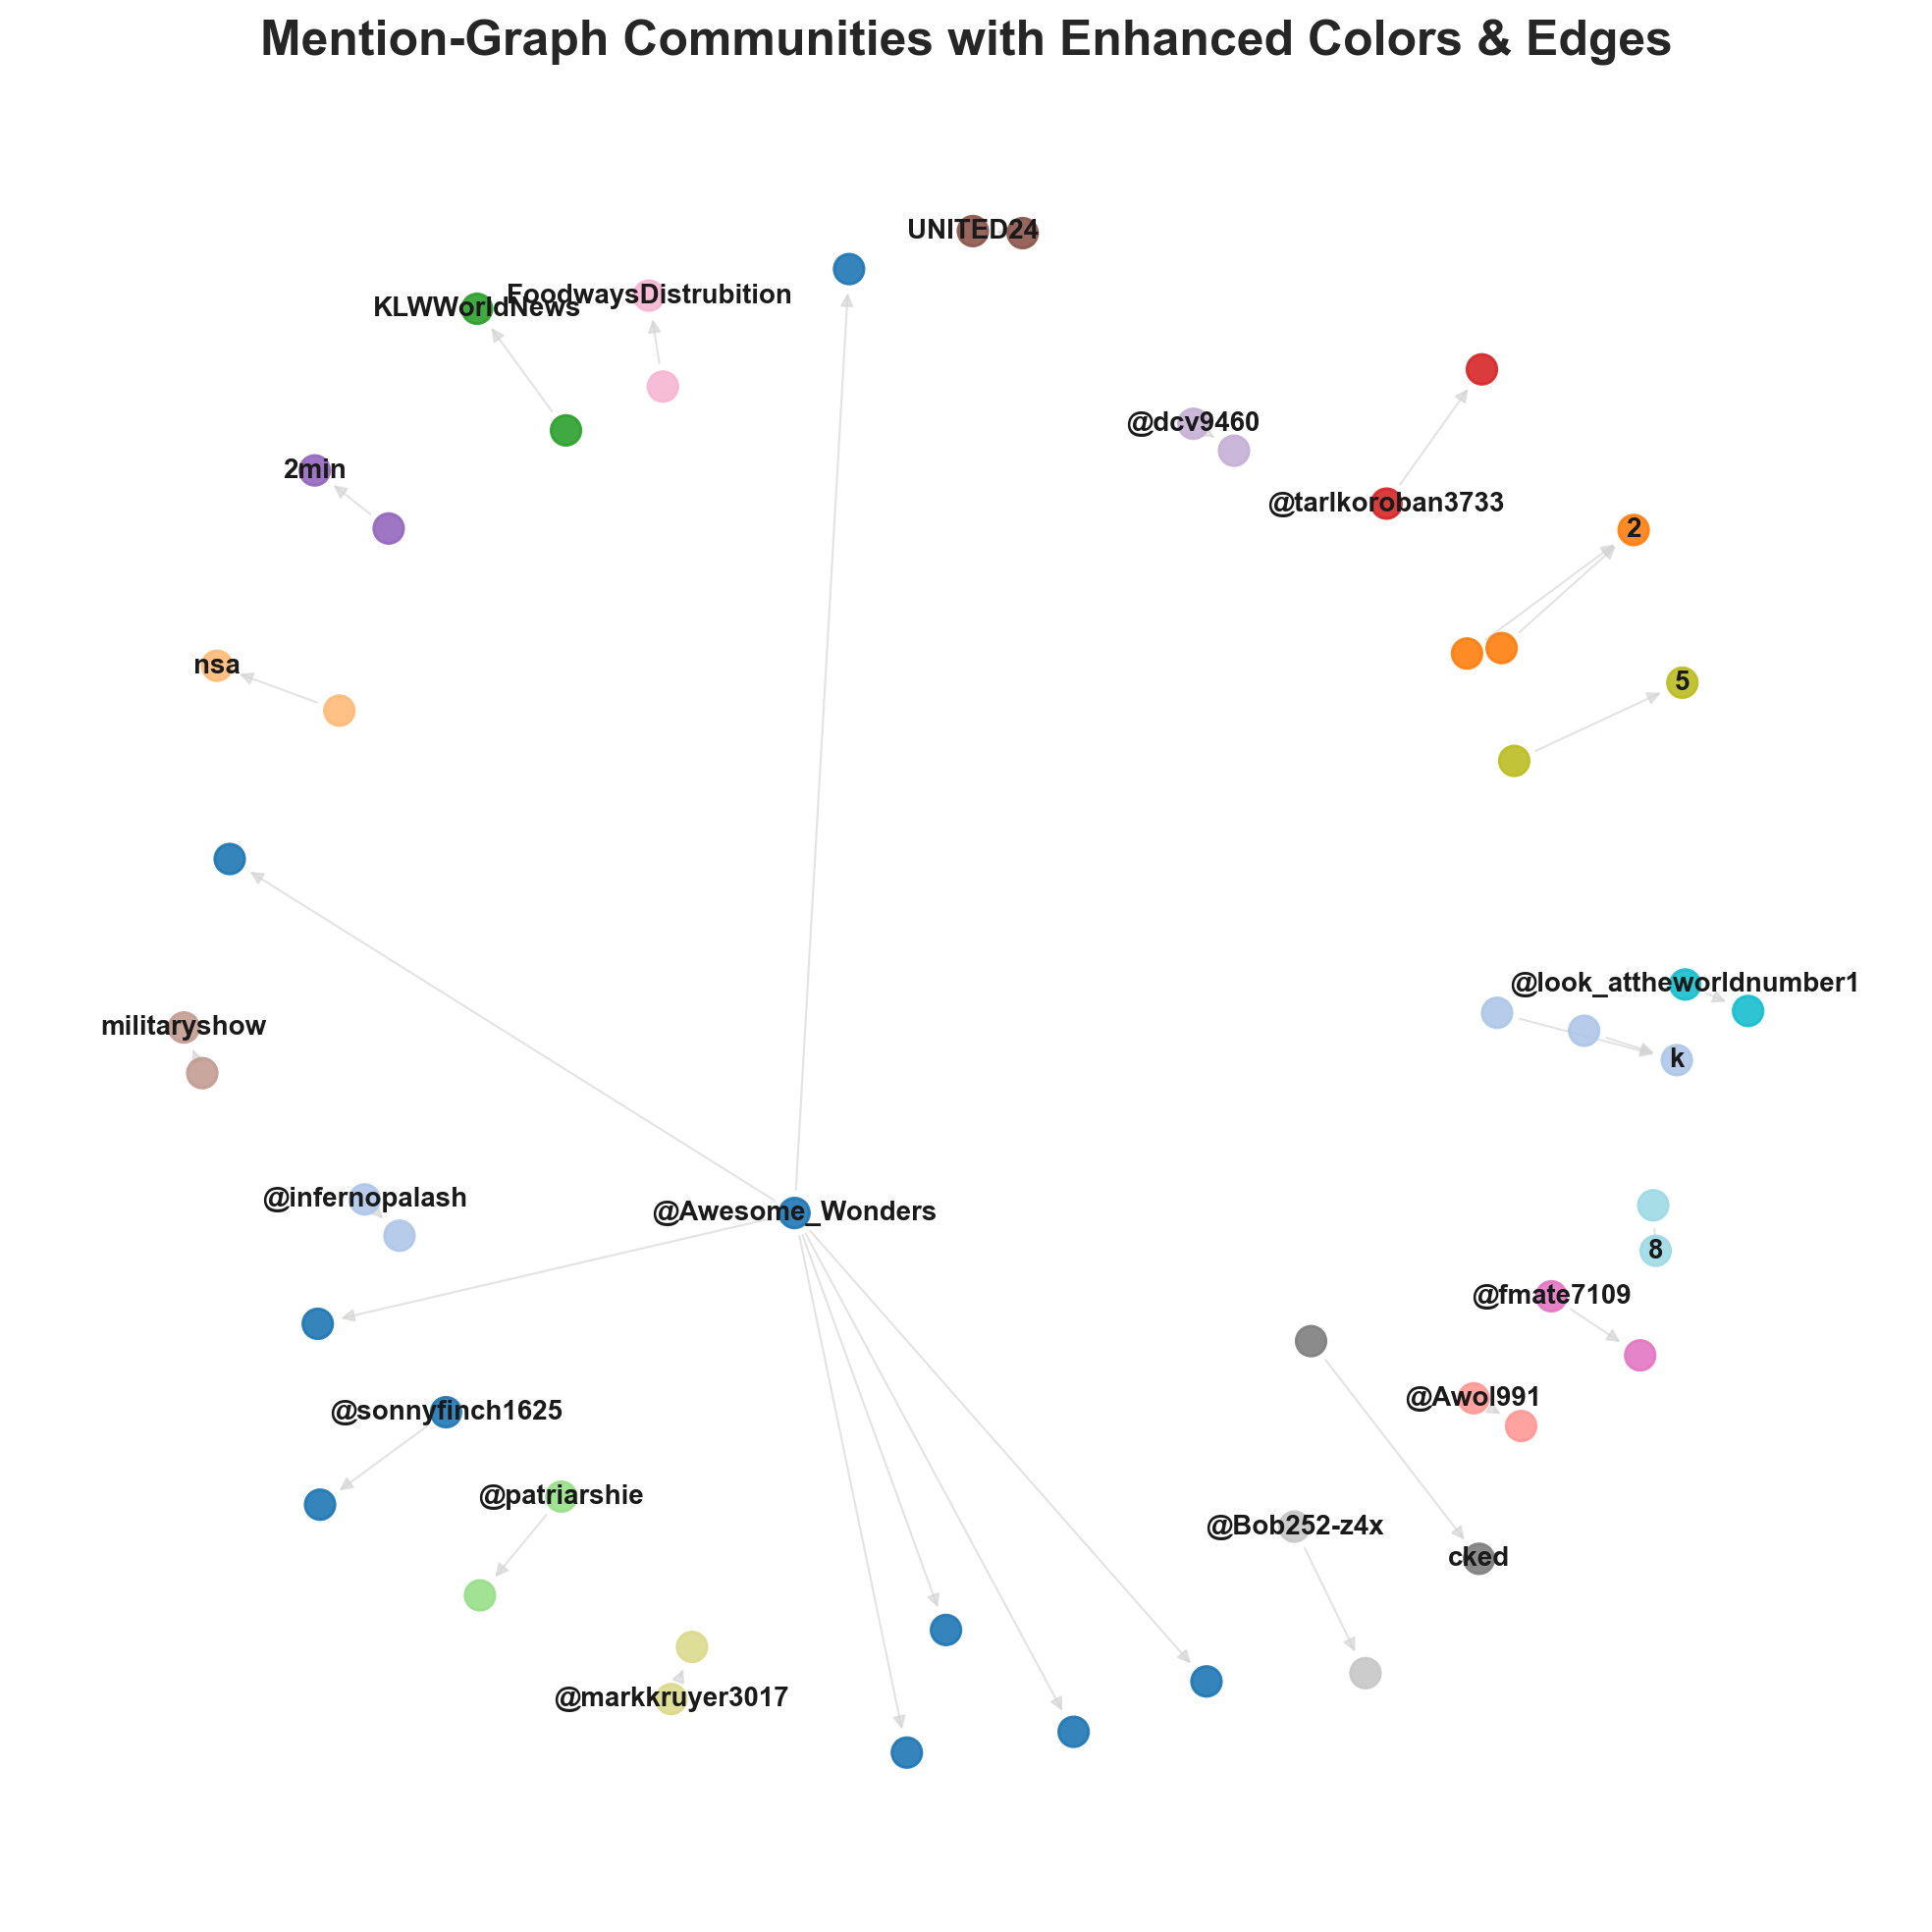

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
from matplotlib.patches import Patch

# — assume G_mention is your directed mention graph —
und = G_mention.to_directed()

# 1) Detect communities
comms = list(community.greedy_modularity_communities(und, weight='weight'))

# 2) Map each node to its community index
comm_map = {n: idx for idx, c in enumerate(comms) for n in c}

# 3) Pick one representative per community (highest-degree)
rep_nodes = {}
for idx, c in enumerate(comms):
    degs = und.subgraph(c).degree()
    rep = max(degs, key=lambda x: x[1])[0]
    rep_nodes[idx] = rep

# 4) Compute layout
pos = nx.spring_layout(und, seed=42, k=0.15)

# 5) Prepare a color palette
cmap = plt.get_cmap('tab20')
colors = cmap.colors

plt.figure(figsize=(10, 10))

# 6) Draw all edges in light gray for visibility
nx.draw_networkx_edges(
    und, pos,
    edge_color='lightgray',
    alpha=0.6,
    width=0.8
)

# 7) Draw nodes, one community at a time, in distinct colors
for idx, c in enumerate(comms):
    nx.draw_networkx_nodes(
        und, pos,
        nodelist=list(c),
        node_size=120,
        node_color=[colors[idx % len(colors)]] * len(c),
        alpha=0.9
    )

# 8) Label only the representative nodes
label_dict = {rep: rep for rep in rep_nodes.values()}
nx.draw_networkx_labels(
    und, pos,
    labels=label_dict,
    font_size=10,
    font_weight='bold'
)

# 9) Add a legend for communities
# legend_handles = [
#     Patch(facecolor=colors[i % len(colors)], label=f'Comm {i}')
#     for i in range(len(comms))
# ]
# plt.legend(
#     handles=legend_handles,
#     title="Communities",
#     loc='upper right',
#     fontsize='small',
#     title_fontsize='medium',
#     frameon=False
# )

plt.title("Mention-Graph Communities with Enhanced Colors & Edges")
plt.axis('off')
plt.tight_layout()
plt.show()



Louvain found 22 communities:
 Community 1 (3 nodes): ['@LoueBlack', '@basem23', 'k']
 Community 2 (2 nodes): ['nsa', '@dissaid']
 Community 3 (2 nodes): ['KLWWorldNews', '@theunknowncomic9047']
 Community 4 (2 nodes): ['@patriarshie', 'MuratSANmedia']
 Community 5 (8 nodes): ['@Awesome_Wonders', 'inian', 'r', 'ine', 'p0ns', 'lest1ne', 'tes', 'st']
 Community 6 (2 nodes): ['@tarlkoroban3733', 'el']
 Community 7 (2 nodes): ['@Awol991', '0']
 Community 8 (2 nodes): ['2min', '@CRAZYHORSE187']
 Community 9 (2 nodes): ['@dcv9460', 'PUTIN']
 Community 10 (3 nodes): ['@aandarcom', '2', '@brucelamberton8819']
 Community 11 (2 nodes): ['UNITED24', '@AdalbertSchneider_']
 Community 12 (2 nodes): ['militaryshow', '@mrpolitics']
 Community 13 (2 nodes): ['@fmate7109', '3']
 Community 14 (2 nodes): ['FoodwaysDistrubition', '@mustafaengin9322']
 Community 15 (2 nodes): ['cked', '@szolanek']
 Community 16 (2 nodes): ['@Bob252-z4x', '4']
 Community 17 (2 nodes): ['5', '@ETmyAz']
 Community 18 (2 node

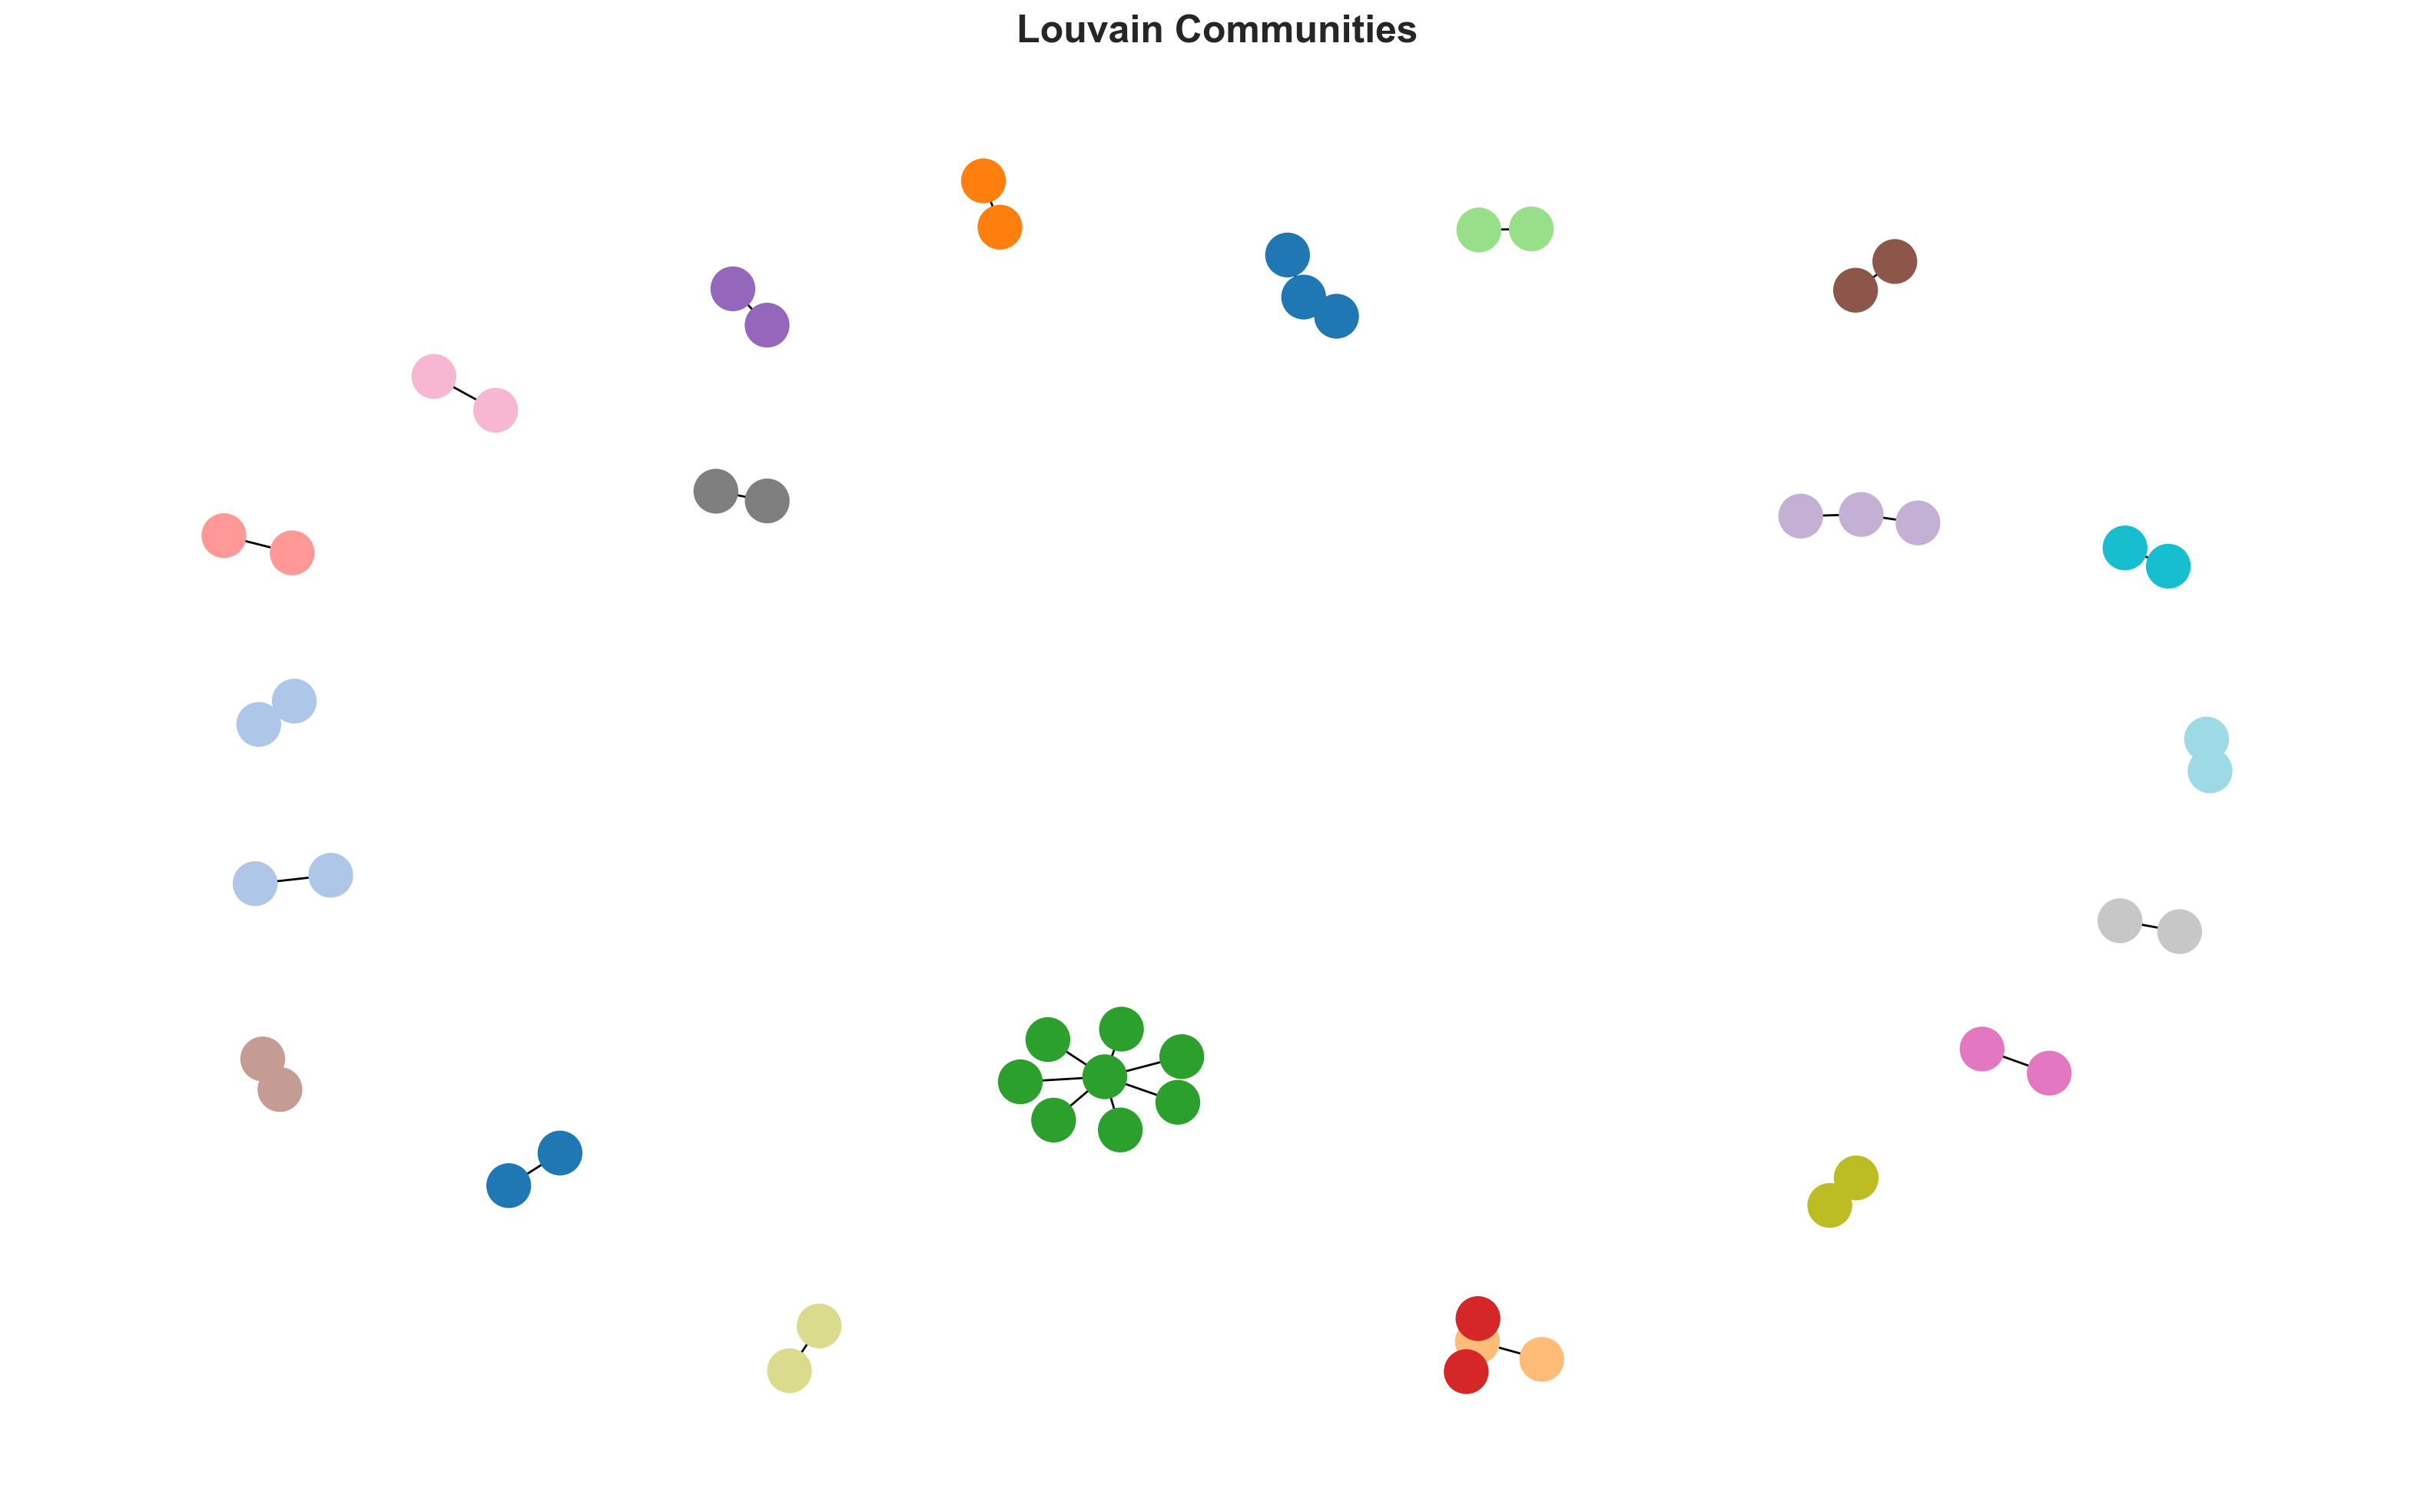

In [15]:
import networkx as nx
from networkx.algorithms import community as nx_comm
import community as community_louvain
import matplotlib.pyplot as plt
from collections import defaultdict

# — assume G_mention is your directed mention graph —
und = G_mention.to_undirected()

# 3) Louvain partition
louvain_part = community_louvain.best_partition(und, weight='weight')
# convert to list-of-sets
louvain_comms = defaultdict(set)
for node, cid in louvain_part.items():
    louvain_comms[cid].add(node)
louvain_comms = list(louvain_comms.values())

print(f"\nLouvain found {len(louvain_comms)} communities:")
for i, comm in enumerate(louvain_comms, 1):
    print(f" Community {i} ({len(comm)} nodes): {list(comm)[:8]}{'…' if len(comm)>8 else ''}")

# 4) Plot helper
def plot_communities(graph, communities, title):
    pos = nx.spring_layout(graph, seed=42, k=0.15)
    cmap = plt.get_cmap('tab20').colors

    # draw edges lightly
    nx.draw_networkx_edges(graph, pos, alpha=1, edge_color='black', width=1)

    # draw each community in its own color
    for idx, comm in enumerate(communities):
        nx.draw_networkx_nodes(
            graph, pos,
            nodelist=list(comm),
            node_size=400,
            node_color=[cmap[idx % len(cmap)]]*len(comm),
            alpha=1,
            label=f'Comm {idx+1}'
        )

    plt.title(title)
    # plt.legend(loc='upper right', fontsize='small', frameon=False)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 5) Visualize both
plot_communities(und, louvain_comms, 'Louvain Communities')


Found 22 communities via Label Propagation
 Community 1 size: 3 : ['@LoueBlack', '@basem23', 'k']
 Community 2 size: 2 : ['nsa', '@dissaid']
 Community 3 size: 2 : ['KLWWorldNews', '@theunknowncomic9047']
 Community 4 size: 2 : ['@patriarshie', 'MuratSANmedia']
 Community 5 size: 8 : ['@Awesome_Wonders', 'inian', 'r', 'ine', 'p0ns', 'lest1ne', 'tes', 'st']
 Community 6 size: 2 : ['@tarlkoroban3733', 'el']
 Community 7 size: 2 : ['@Awol991', '0']
 Community 8 size: 2 : ['2min', '@CRAZYHORSE187']
 Community 9 size: 2 : ['@dcv9460', 'PUTIN']
 Community 10 size: 3 : ['@aandarcom', '2', '@brucelamberton8819']
 Community 11 size: 2 : ['UNITED24', '@AdalbertSchneider_']
 Community 12 size: 2 : ['militaryshow', '@mrpolitics']
 Community 13 size: 2 : ['@fmate7109', '3']
 Community 14 size: 2 : ['FoodwaysDistrubition', '@mustafaengin9322']
 Community 15 size: 2 : ['cked', '@szolanek']
 Community 16 size: 2 : ['@Bob252-z4x', '4']
 Community 17 size: 2 : ['5', '@ETmyAz']
 Community 18 size: 2 : ['

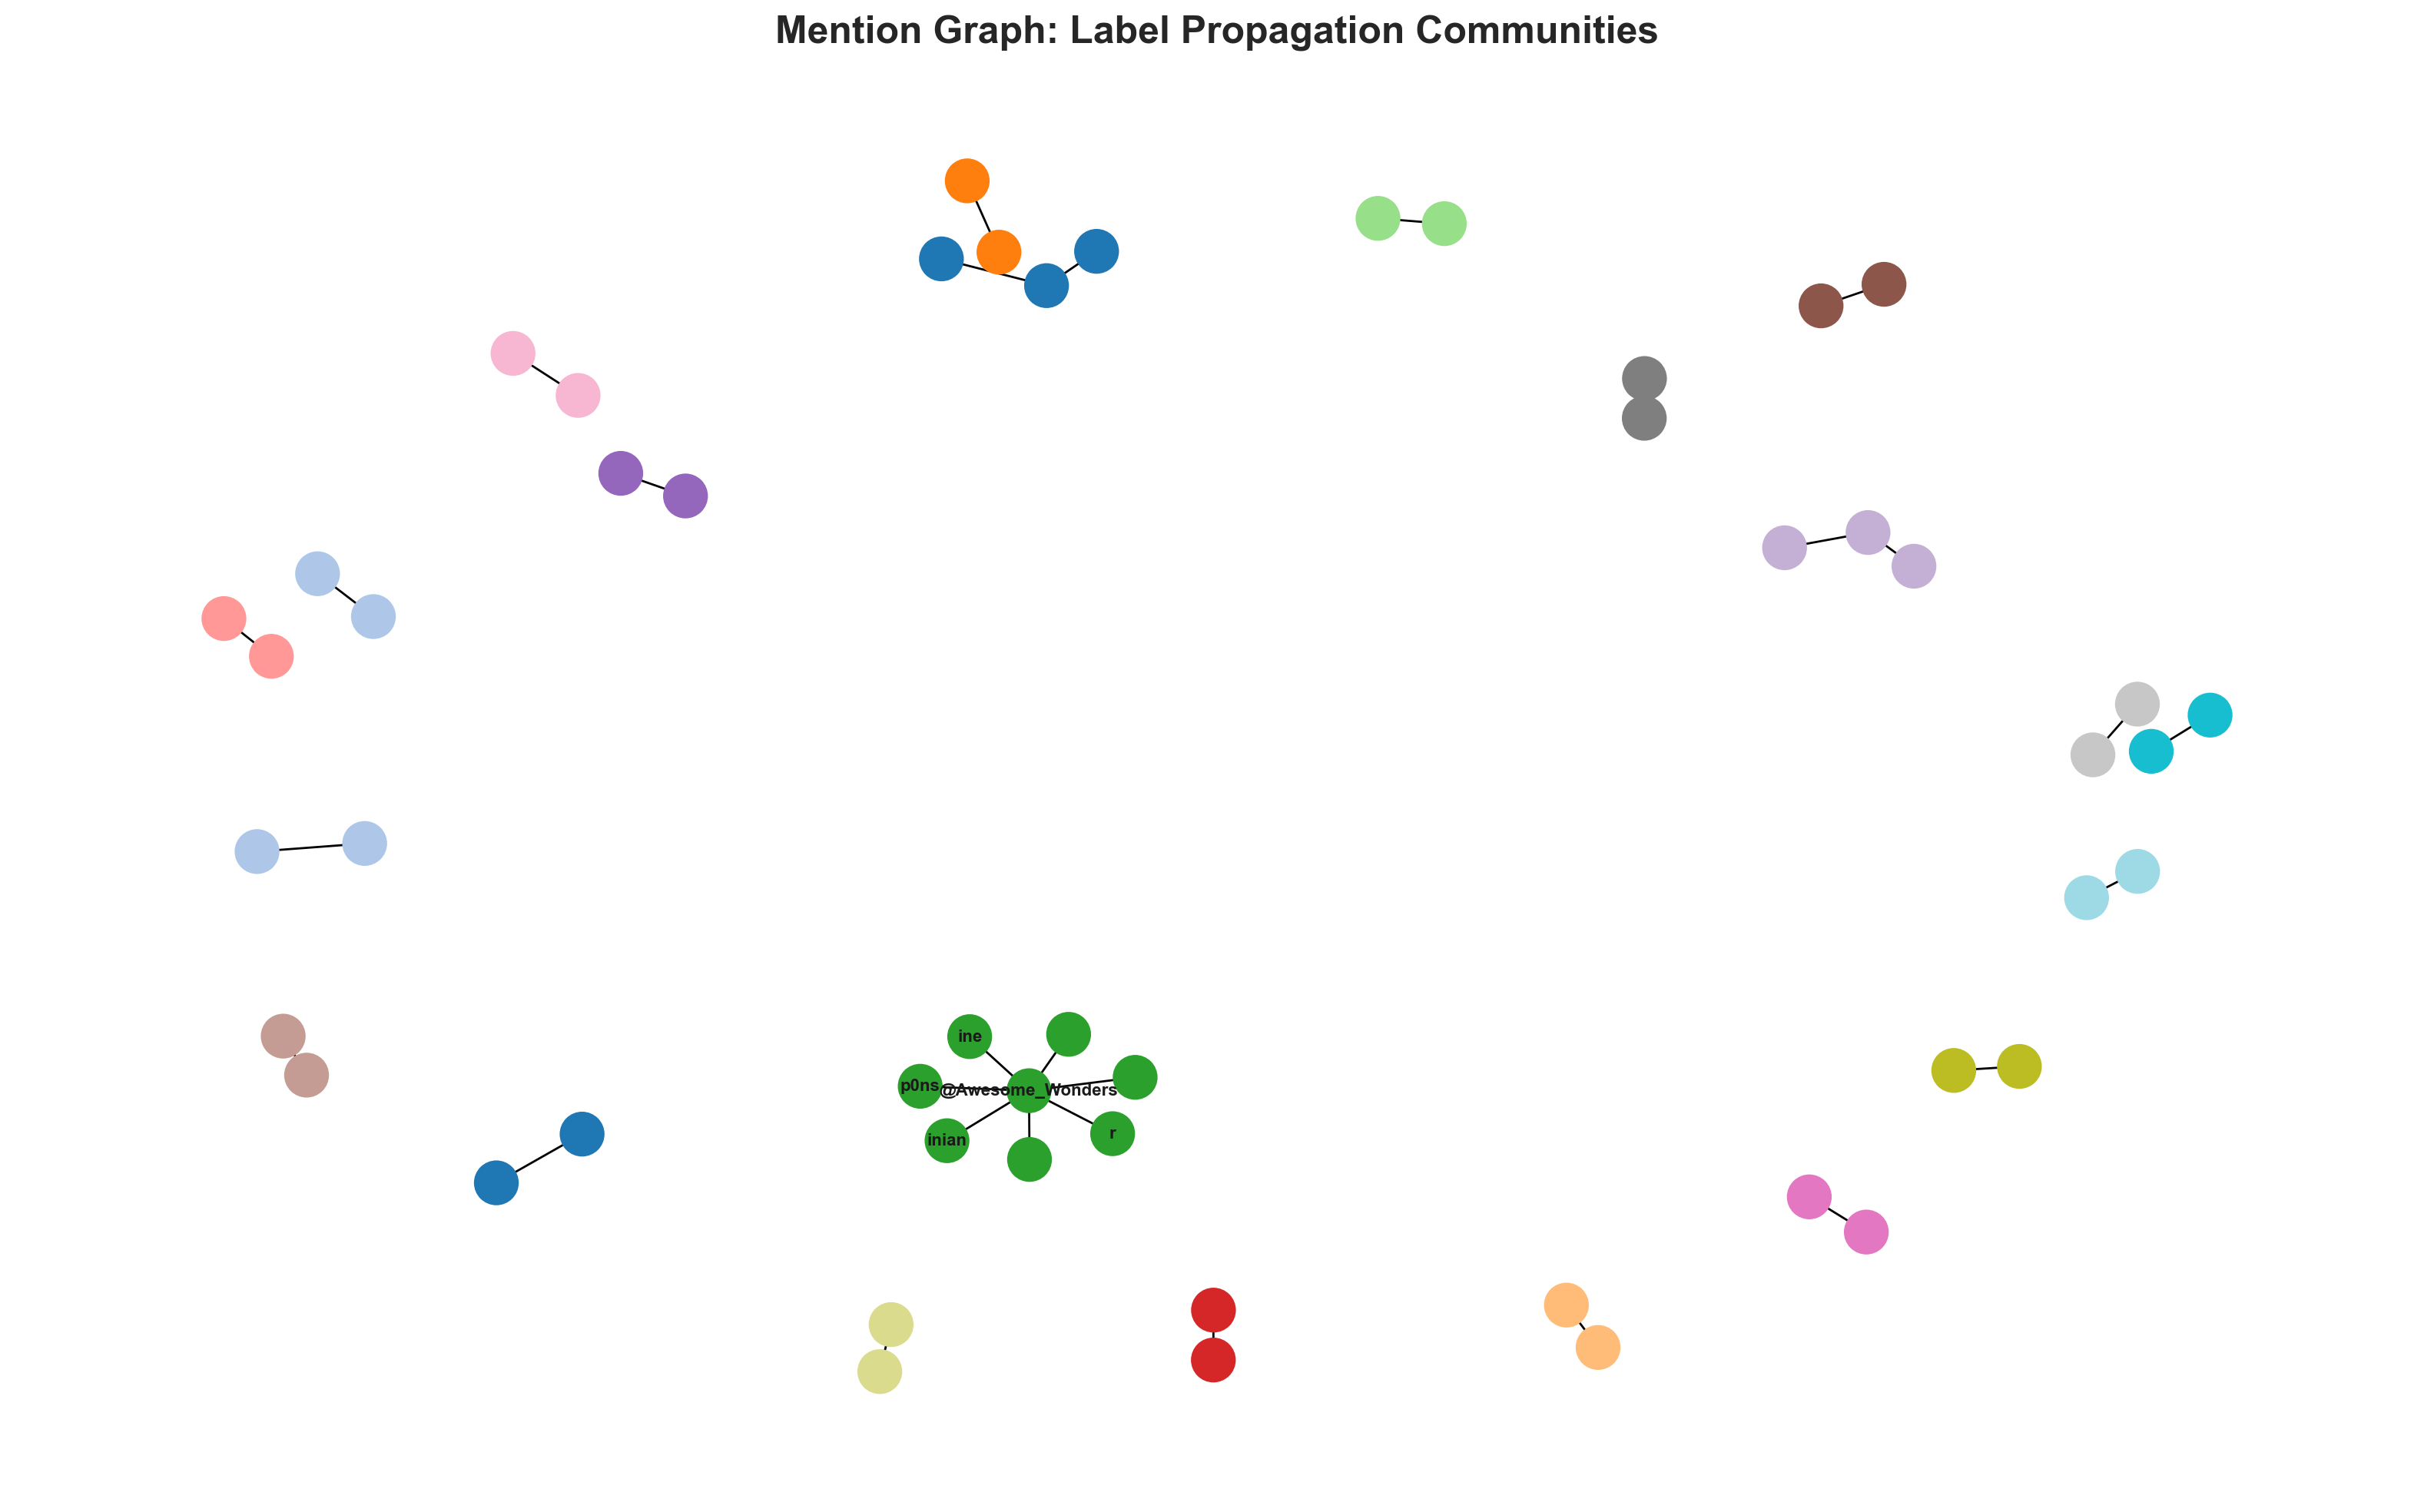

In [16]:
import networkx as nx
from networkx.algorithms.community import asyn_lpa_communities, label_propagation_communities
import matplotlib.pyplot as plt

# 1) Convert to undirected
und = G_mention.to_undirected()

# 2) Run asynchronous label propagation
label_comms = list(asyn_lpa_communities(und, weight='weight'))
print(f"Found {len(label_comms)} communities via Label Propagation")
for i, comm in enumerate(label_comms, 1):
    print(f" Community {i} size: {len(comm)} : {list(comm)[:8]}{'…' if len(comm)>8 else ''}")

# 3) Map node → community id
label_map = {}
for idx, comm in enumerate(label_comms):
    for n in comm:
        label_map[n] = idx
nx.set_node_attributes(und, label_map, 'label_comm')

# 4) Visualize communities
pos = nx.spring_layout(und, seed=42, k=0.2)
cmap = plt.get_cmap('tab20').colors

# plt.figure(figsize=(8,8))
nx.draw_networkx_edges(und, pos, edge_color='black', alpha=1)

for idx, comm in enumerate(label_comms):
    nx.draw_networkx_nodes(
        und, pos,
        nodelist=list(comm),
        node_color=[cmap[idx % len(cmap)]]*len(comm),
        node_size=400,
        alpha=1,
        label=f'Comm {idx+1}'
    )

# label the largest community’s top 5 degree nodes

deg = dict(und.degree())
largest = max(label_comms, key=len)
top5 = sorted(largest, key=lambda n: deg[n], reverse=True)[:5]
labels = {n: n for n in top5}
nx.draw_networkx_labels(und, pos, labels, font_size=8, font_weight='bold')

plt.title("Mention Graph: Label Propagation Communities")
# plt.legend(loc='upper right', fontsize='small', frameon=False)
plt.axis('off')
plt.tight_layout()
plt.show()


In [17]:
partition_louvain = community_louvain.best_partition(G_mention.to_undirected())
nx.set_node_attributes(G_mention, partition_louvain, 'community_louvain')
 
# Label Propagation (built-in method)
label_prop_gen = label_propagation_communities(G_mention.to_undirected())
partition_label = {}
for i, community in enumerate(label_prop_gen):
    for node in community:
        partition_label[node] = i
nx.set_node_attributes(G_mention, partition_label, 'community_labelprop')
 
print(f"Louvain communities: {len(set(partition_louvain.values()))}")
print(f"Label Propagation communities: {len(set(partition_label.values()))}")

Louvain communities: 22
Label Propagation communities: 22


In [18]:
mod_louvain = community_louvain.modularity(partition_louvain, G_mention.to_undirected())
mod_labelprop = nx.algorithms.community.quality.modularity(G_mention.to_undirected(), [
    [n for n, cid in partition_label.items() if cid == c] for c in set(partition_label.values())
])
 
print(f"Louvain Modularity Score: {mod_louvain:.4f}")
print(f"Label Propagation Modularity Score: {mod_labelprop:.4f}")
 

Louvain Modularity Score: 0.9157
Label Propagation Modularity Score: 0.9157


In [19]:
########################################## STAGE 6 : Information Diffusion Simulation ##########################################




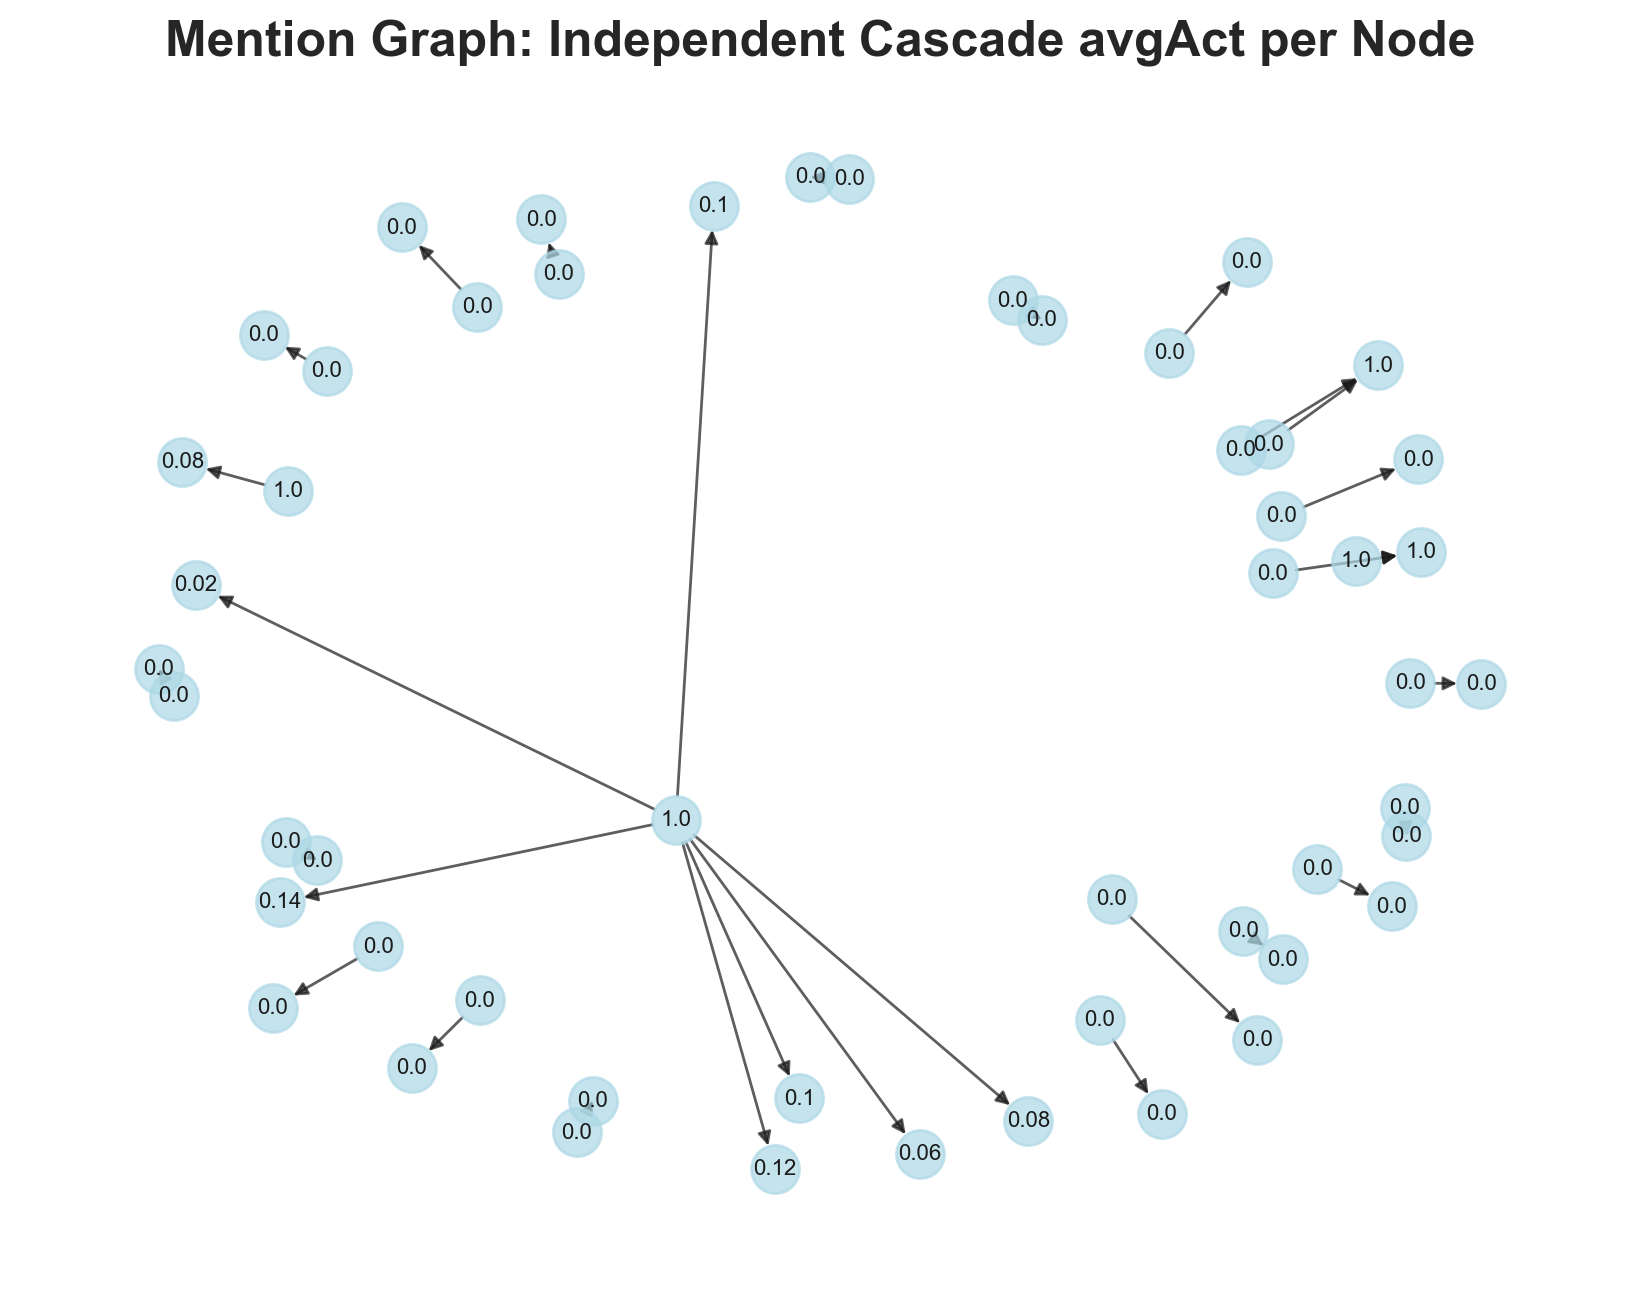

In [20]:
import re
import random
import networkx as nx
import matplotlib.pyplot as plt

# ------------------------------
# Utility: Independent Cascade
# ------------------------------
def independentCascade(graph, trialNum, seed_nodes, activationProb):
    """
    Performs independent cascade over the input graph.
    Returns:
      avgActFrac: dict node -> average activation fraction over trials
      iterActivations: list of total active count per trial
    """
    # Initialize counts
    act_count = {node: 0 for node in graph.nodes()}
    iterActivations = []

    for i in range(trialNum):
        active = set(seed_nodes)
        newly_active = set(seed_nodes)
        # Cascade
        while newly_active:
            next_active = set()
            for u in newly_active:
                for v in graph.neighbors(u):
                    if v not in active and random.random() < activationProb:
                        next_active.add(v)
            newly_active = next_active
            active |= next_active
        # Record
        for node in active:
            act_count[node] += 1
        iterActivations.append(len(active))

    # Compute average activation fraction per node
    avgActFrac = {node: act_count[node] / trialNum for node in graph.nodes()}
    return avgActFrac, iterActivations

# ------------------------------
# Stage 4 outputs assumed:
# G_mention : directed mention graph
# G_tag     : undirected tag co-occurrence graph
# ------------------------------

# ------------------------------
# Stage 6 on Mention Graph
# ------------------------------
# 1) Select seed nodes: top-5 by degree centrality
deg_cent_mention = nx.degree_centrality(G_mention)
seeds_mention = sorted(deg_cent_mention, key=deg_cent_mention.get, reverse=True)[:5]

# 2) Run independent cascade
trialNum = 50
activationProb = 0.1
avgActMention, iterMention = independentCascade(G_mention, trialNum, seeds_mention, activationProb)

# 3) Assign avg activation as node attribute and save GraphML
nx.set_node_attributes(G_mention, avgActMention, 'avgAct')
mention_filename = 'mention_workshop10.graphml'
nx.write_graphml(G_mention, mention_filename, infer_numeric_types=True)

# 4) Visualize Mention Graph with avgAct labels
replyMention = nx.read_graphml(mention_filename)
pos = nx.spring_layout(replyMention, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(replyMention, pos, with_labels=False, node_size=300, node_color='lightblue', alpha=0.7)
labels = {n: round(replyMention.nodes[n]['avgAct'], 2) for n in replyMention.nodes()}
nx.draw_networkx_labels(replyMention, pos, labels=labels, font_size=8)
plt.title("Mention Graph: Independent Cascade avgAct per Node")
plt.axis('off')
plt.tight_layout()
plt.show()



Seed nodes: ['@ComunistaIndio', '@dalanik', '@denisdavidoff624']
Total activated users: 2182
Diffusion steps: 9


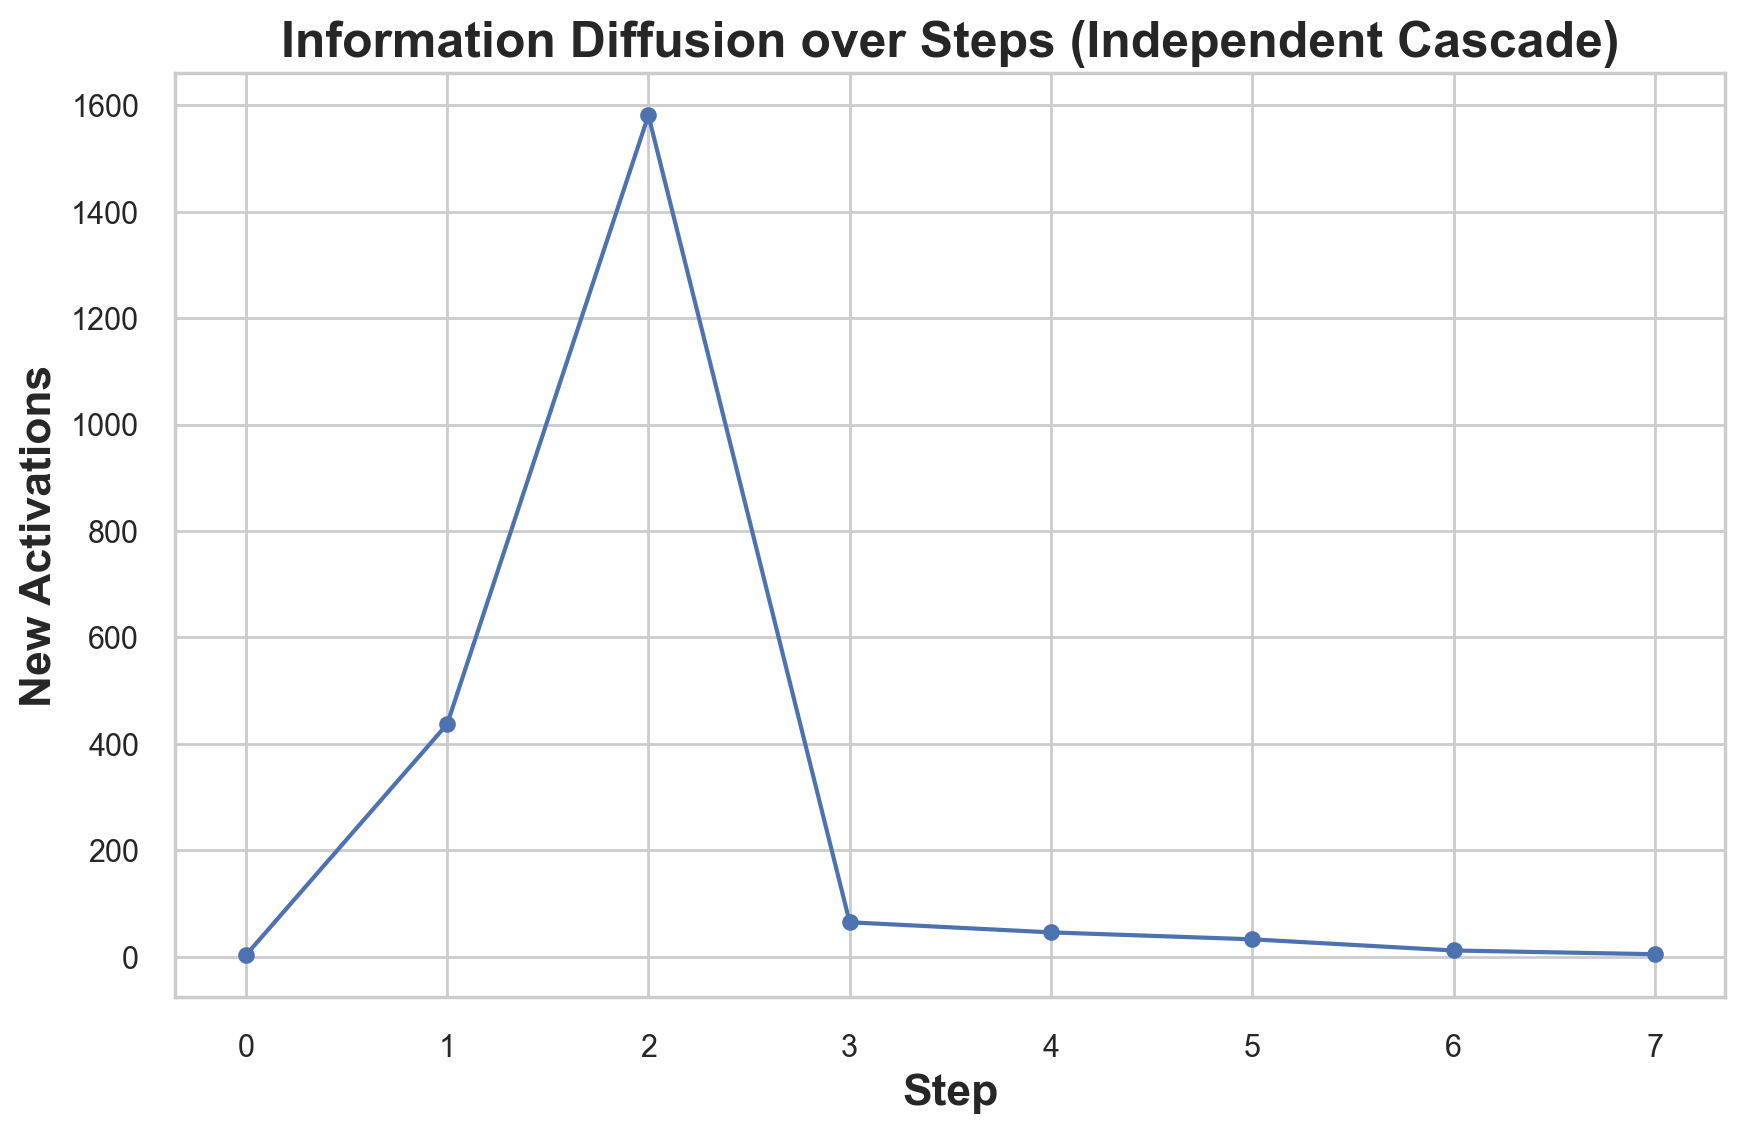

In [21]:


# --- Load dataset ---
df = pd.read_csv("../Data/youtube_video_comments.csv")

# --- Filter out relevant columns and drop missing authors ---
comments_df = df[df["type"] == "comment"].dropna(subset=["c_author", "c_publishedAt"])
comments_df["c_publishedAt"] = pd.to_datetime(comments_df["c_publishedAt"])

# --- Choose one video (most commented one) ---
top_video = comments_df["videoId"].value_counts().idxmax()
video_comments = comments_df[comments_df["videoId"] == top_video].copy()

# --- Sort comments by timestamp ---
video_comments.sort_values("c_publishedAt", inplace=True)

# --- Build a directed graph based on comment order ---
G = nx.DiGraph()
authors = video_comments["c_author"].tolist()

# Create edges: earlier commenters can influence later ones
for i in range(len(authors)):
    for j in range(i + 1, len(authors)):
        if authors[i] != authors[j]:  # avoid self-loops
            G.add_edge(authors[i], authors[j])

# --- Independent Cascade Simulation ---
def independent_cascade(G, seed_nodes, p=0.1, steps=0):
    activated = set(seed_nodes)
    newly_activated = set(seed_nodes)
    cascade_steps = [set(seed_nodes)]

    while newly_activated:
        next_activated = set()
        for node in newly_activated:
            for neighbor in G.successors(node):
                if neighbor not in activated:
                    if random.random() < p:
                        next_activated.add(neighbor)
        newly_activated = next_activated
        activated.update(newly_activated)
        cascade_steps.append(set(newly_activated))
        steps += 1

    return activated, cascade_steps

# --- Run the simulation ---
random.seed(42)
seed_nodes = random.sample(list(G.nodes), k=3)  # Choose 3 random seeds

final_activated, diffusion_steps = independent_cascade(G, seed_nodes, p=0.1)

# --- Output summary ---
print(f"Seed nodes: {seed_nodes}")
print(f"Total activated users: {len(final_activated)}")
print(f"Diffusion steps: {len(diffusion_steps)}")

# --- Optional: plot diffusion steps ---
sizes = [len(step) for step in diffusion_steps if step]
plt.figure(figsize=(10, 6))
plt.plot(range(len(sizes)), sizes, marker="o")
plt.title("Information Diffusion over Steps (Independent Cascade)")
plt.xlabel("Step")
plt.ylabel("New Activations")
plt.grid(True)
plt.show()


In [ ]:
# --- Plot the graph with seed and activated nodes highlighted ---
plt.figure(figsize=(12, 10))

# Layout for positioning
pos = nx.spring_layout(G, seed=42)

# Draw all nodes as inactive by default
nx.draw_networkx_nodes(G, pos, node_color="lightgray", node_size=100, label="Inactive")

# Draw activated nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=list(final_activated),
    node_color="orange",
    node_size=150,
    label="Activated"
)

# Draw seed nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=seed_nodes,
    node_color="red",
    node_size=200,
    label="Seed Nodes"
)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, arrows=True)

# Optional: Labels (disable for large graphs)
# nx.draw_networkx_labels(G, pos, font_size=6)

plt.title("Information Diffusion Graph (Independent Cascade Model)")
plt.legend()
plt.axis("off")
plt.show()


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001CDAA3904A0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 